#### ***Lab 1: Gaia, RR Lyrae stars, and Galactic Dust***
#### **ASTRON 128 – Fall 2024**
#### *Vardaan Tekriwal*

#### **Imports and Caching**

The caching function has the following functionality:

"""
    Execute a Gaia query and parse the results into a pandas DataFrame.
    Save the results to a file for future use. If no filename is provided,
    it guesses the output filename based on the query.
    
    Parameters:
    - query: str, the query to execute
    - local_filename: str, optional, the filename to save or load the results
    - verbose: bool, optional, whether to print verbose output
    - overwrite: bool, optional, whether to overwrite the existing file
    
    Returns: dataframe
    """

In [83]:
import os
import time
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from astropy import units as u
from astropy.timeseries import LombScargle
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import pymc as pm
import arviz as az
import matplotlib.patches as mpatches
from astropy.coordinates import SkyCoord
import pymc.math as pm_math

%matplotlib inline

In [5]:
def get_and_parse_cached_gaia_query(query, local_filename=None, verbose=True, overwrite=False):
    
    # Create a default filename based on a hash of the query if not provided
    if local_filename is None:
        local_filename = f"gaia_query_{hash(query)}.csv"
        
    if not os.path.exists(local_filename) or overwrite:
        start = time.time()
        job = Gaia.launch_job(query)
        results = job.get_results()
        
        df = results.to_pandas()
        df.to_csv(local_filename, index=False)
        
        if verbose:
            print(f"Wrote the file {local_filename} to disk", flush=True)
            print(f"  Total time: {time.time() - start:0.3} sec")
    else:
        start = time.time()
        if verbose:
            print(f"Reading the file {local_filename} from disk")
        df = pd.read_csv(local_filename)
        if verbose:
            print(f"  Total time: {time.time() - start:0.3} sec")
    return df


In [6]:
query = """
SELECT TOP 100 *
FROM gaiadr3.vari_rrlyrae
WHERE pf IS NOT NULL
AND num_clean_epochs_g > 40
"""

rr_lyrae_df = get_and_parse_cached_gaia_query(query, "rrlyrae_gaia_data.csv", verbose=True, overwrite = False)
rr_lyrae_df.head(10)

Reading the file rrlyrae_gaia_data.csv from disk
  Total time: 0.0164 sec


,solution_id,SOURCE_ID,pf,pf_error,p1_o,p1_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,...,fund_freq1_harmonic_ampl_rp_error,fund_freq1_harmonic_phase_rp,fund_freq1_harmonic_phase_rp_error,fund_freq1_harmonic_ampl_rv,fund_freq1_harmonic_ampl_rv_error,fund_freq1_harmonic_phase_rv,fund_freq1_harmonic_phase_rv_error,best_classification,g_absorption,g_absorption_error
0,375316653866487565,245002531050576896,0.520512,0.000006,NaN,NaN,1705.132336,0.000008,1705.141478,0.000010,...,[0.010494326241314411 0.016995785757899284 0.0...,[1.1146807670593262 0.1373586654663086 5.74105...,[0.06407403200864792 0.13510026037693024 0.176...,NaN,NaN,NaN,NaN,RRab,1.122552,0.077198
1,375316653866487565,245504251951140864,0.507115,0.000004,NaN,NaN,1705.941237,0.000006,1705.959324,0.000018,...,[0.0760503038764 0.047721847891807556 0.060700...,[4.1733903884887695 5.874802589416504 3.042095...,[0.4473535418510437 0.3156072497367859 0.54333...,NaN,NaN,NaN,NaN,RRab,2.049920,0.235075
2,375316653866487565,245823861938360064,0.478764,0.000003,NaN,NaN,1705.224346,0.000004,1705.720646,0.000042,...,[0.031176093965768814 0.035711657255887985 -- ...,[2.76688814163208 3.016339063644409 0.0 0.0 0....,[0.3435215651988983 0.5497013330459595 -- -- -...,NaN,NaN,NaN,NaN,RRab,1.247847,0.149523
3,375316653866487565,246756973652292992,0.489303,0.000003,NaN,NaN,1705.694932,0.000004,1705.689886,0.000004,...,[0.030727090314030647 0.047870539128780365 0.0...,[4.562902450561523 0.4658964276313782 3.892376...,[0.13615591824054718 0.6346452236175537 0.8997...,[24.761327743530273 8.276593208312988 6.709530...,[2.1693670749664307 3.686511754989624 4.079475...,[4.298094749450684 0.44723403453826904 3.06022...,[0.11782895028591156 0.5129826068878174 0.7093...,RRab,1.708960,0.138106
4,375316653866487565,359112665277840512,0.501780,0.000003,NaN,NaN,1700.672707,0.000004,1700.674042,0.000002,...,[0.018822116777300835 0.013632036745548248 0.0...,[2.2174336910247803 1.9805796146392822 2.17451...,[0.04635436832904816 0.18070566654205322 0.199...,NaN,NaN,NaN,NaN,RRab,0.366922,0.099340
5,375316653866487565,414003442535159936,0.474868,0.000003,NaN,NaN,1699.303859,0.000004,1699.307985,0.000007,...,[0.020318111404776573 0.022703826427459717 0.0...,[3.2704927921295166 4.007861137390137 5.968933...,[0.23768164217472076 0.5128516554832458 0.6803...,NaN,NaN,NaN,NaN,RRab,1.228615,0.116031
6,375316653866487565,414081061185873792,0.588920,0.000003,NaN,NaN,1698.628868,0.000004,1698.665720,0.000010,...,[0.0256697665899992 -- -- -- -- -- -- -- -- --...,[3.2015879154205322 0.0 0.0 0.0 0.0 0.0 0.0 0....,[1.6511130332946777 -- -- -- -- -- -- -- -- --...,NaN,NaN,NaN,NaN,RRab,1.533338,0.127030
7,375316653866487565,414152842984521856,0.364381,0.000016,NaN,NaN,1699.044868,0.000023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RRab,NaN,NaN
8,375316653866487565,414254032403091072,0.418104,0.000004,NaN,NaN,1699.358285,0.000006,1699.372824,0.000023,...,[0.02068113349378109 0.03187503293156624 -- --...,[5.0545525550842285 1.57941734790802 0.0 0.0 0...,[0.28810054063796997 0.6072249412536621 -- -- ...,NaN,NaN,NaN,NaN,RRab,2.343221,0.115202
9,375316653866487565,415000566440590976,0.617383,0.000004,NaN,NaN,1697.739636,0.000005,1697.741188,0.000006,...,[0.004727639257907867 0.005540942773222923 0.0...,[4.1175217628479 0.6510999202728271 3.58330011...,[0.06876092404127121 0.1189626082777977 0.3158...,NaN,NaN,NaN,NaN,RRab,0.483881,0.053500


In [7]:
rr_lyrae_df.columns

Index(['solution_id', 'SOURCE_ID', 'pf', 'pf_error', 'p1_o', 'p1_o_error',
       'epoch_g', 'epoch_g_error', 'epoch_bp', 'epoch_bp_error', 'epoch_rp',
       'epoch_rp_error', 'epoch_rv', 'epoch_rv_error', 'int_average_g',
       'int_average_g_error', 'int_average_bp', 'int_average_bp_error',
       'int_average_rp', 'int_average_rp_error', 'average_rv',
       'average_rv_error', 'peak_to_peak_g', 'peak_to_peak_g_error',
       'peak_to_peak_bp', 'peak_to_peak_bp_error', 'peak_to_peak_rp',
       'peak_to_peak_rp_error', 'peak_to_peak_rv', 'peak_to_peak_rv_error',
       'metallicity', 'metallicity_error', 'r21_g', 'r21_g_error', 'r31_g',
       'r31_g_error', 'phi21_g', 'phi21_g_error', 'phi31_g', 'phi31_g_error',
       'num_clean_epochs_g', 'num_clean_epochs_bp', 'num_clean_epochs_rp',
       'num_clean_epochs_rv', 'zp_mag_g', 'zp_mag_bp', 'zp_mag_rp',
       'num_harmonics_for_p1_g', 'num_harmonics_for_p1_bp',
       'num_harmonics_for_p1_rp', 'num_harmonics_for_p1_rv',
       '

In [8]:
source_id = 4659713442253931776

query = f"""
SELECT *
FROM gaiadr3.vari_rrlyrae
WHERE source_id = {source_id}
"""
def get_specific_rrlyrae_data(query):
    job = Gaia.launch_job_async(query)
    result = job.get_results()
    return result.to_pandas()

specific_rr_lyrae_data = get_specific_rrlyrae_data(query)
print(f"Retrieved {len(specific_rr_lyrae_data)} rows for source_id {source_id}.")

INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 1 rows for source_id 4659713442253931776.


In [9]:
rr_lyrae_df = pd.concat([rr_lyrae_df, specific_rr_lyrae_data], ignore_index=True)

/var/folders/yb/gm3s7q8j7rjchq61y16sy76c0000gn/T/ipykernel_27139/4292612220.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rr_lyrae_df = pd.concat([rr_lyrae_df, specific_rr_lyrae_data], ignore_index=True)


In [10]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  vtekriwa
Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [13]:
source_ids = rr_lyrae_df['SOURCE_ID'].tolist()

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'
format_type = 'votable'

datalink = Gaia.load_data(ids=source_ids, data_release=data_release, 
                          retrieval_type=retrieval_type, data_structure=data_structure, 
                          verbose=False, output_file=None, format=format_type)

dl_keys = [key for key in datalink.keys()]
dl_keys.sort()

print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')

The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 1933740099389964544.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1933774424769244672.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1933932037186583808.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934025701833533056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934205880002515456.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934591533705740928.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934784777174637056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934869366550952448.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935104150941800320.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935230693559394816.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935418400810447744.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935591853067670912.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935623189149153664.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935783924006493056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936034303418884992.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936052754598476416.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936068285199840128.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936256744066915

In [14]:
def estimate_period_lombscargle(time, magnitude, magnitude_error):
    time = np.array(time)
    min_period = 0.2  # days
    max_period = 1  # days
    frequency, power = LombScargle(time, magnitude, magnitude_error).autopower(
        minimum_frequency=1/max_period, 
        maximum_frequency=1/min_period
    )
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency

    return best_period, frequency, power

def calculate_mean_magnitude(flux, flux_err):
    mean_flux = np.mean(flux)
    mean_flux_err = np.sqrt(np.sum(flux_err**2)) / len(flux_err) 
    mean_mag = -2.5 * np.log10(mean_flux)
    mean_mag_err = (2.5 / np.log(10)) * (mean_flux_err / mean_flux)
    return mean_mag, mean_mag_err

def plot_light_curve(time, magnitude, magnitude_error, mean_magnitude, mean_magnitude_error):
    magnitude = magnitude.to(u.mag) 
    magnitude_error = magnitude_error.to(u.mag)
    plt.errorbar(
        time, magnitude.value, yerr=magnitude_error.value,
        fmt='o', label='G-band', color='blue',
        ecolor='black', elinewidth=1, capsize=2,
        markeredgewidth=1, markersize=1  # Reduced marker size
    )
    plt.axhline(
        mean_magnitude, color='red', linestyle='--',
        label=f'Mean Magnitude: {mean_magnitude:.3f} mag'
    )
    plt.fill_between(
        time, mean_magnitude - mean_magnitude_error, 
        mean_magnitude + mean_magnitude_error,
        color='red', alpha=0.2,
        label=f'± Mean Error: {mean_magnitude_error:.3f} mag'
    )
    plt.gca().invert_yaxis()  
    plt.xlabel('Time (JD)')
    plt.ylabel('G-band Magnitude')
    plt.title('Light Curve')
    plt.legend()
    plt.show()

def plot_periodogram(frequency, power, best_period):
    periods = 1 / frequency
    plt.plot(periods, power)
    plt.axvline(best_period, color='red', linestyle='--', label=f'Estimated Period: {best_period:.3f} days')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram')
    plt.legend()
    plt.show()

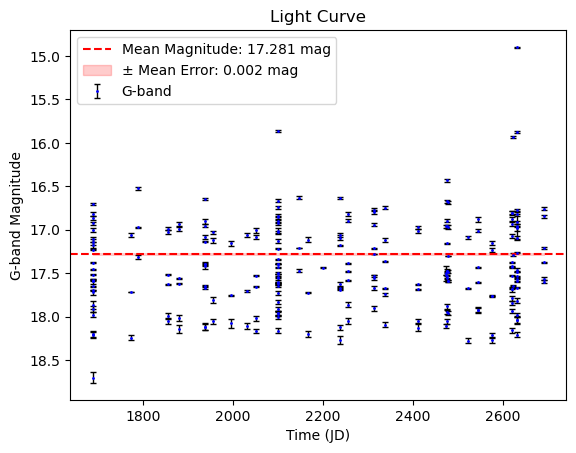

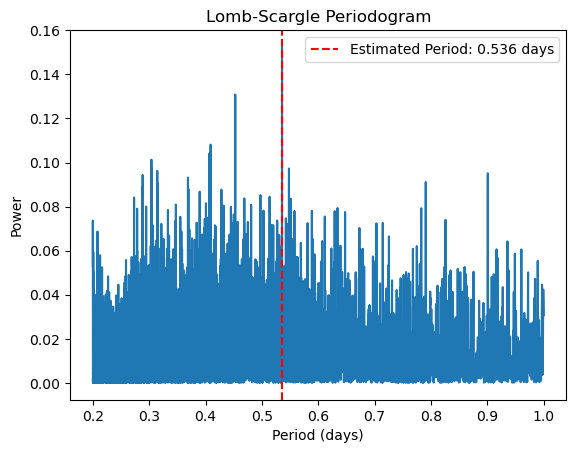

Estimated Period: 0.536 days
Mean G-band Magnitude: 17.281 ± 0.002


In [15]:
estimated_periods = []
mean_magnitudes = []
mean_magnitude_errors = []

for idx, dl_key in enumerate(dl_keys):
    light_curve_data = datalink[dl_key][0].to_table()

    time = light_curve_data['time']
    flux = light_curve_data['flux'] 
    flux_error = light_curve_data['flux_error']

    if hasattr(light_curve_data['mag'], 'unit'):
        mag = light_curve_data['mag']
    else:
        mag = light_curve_data['mag'] * u.mag  

    valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
    time = time[valid_mask]
    mag = mag[valid_mask]
    flux = flux[valid_mask]
    flux_error = flux_error[valid_mask]
    
    if len(time) < 2:
        print(f"Light curve {idx+1}: Not enough valid data points after filtering.")
        continue
    
    mag_err = (2.5 / np.log(10)) * (flux_error / flux)
    mag_err = mag_err * u.mag  # Assign units after calculation

    flux_linear = 10**(-0.4 * mag.value) 
    flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5

    if isinstance(time, u.Quantity): 
        time = time.to(u.day).value  
    else:
        time = np.array(time)  

    best_period, frequency, power = estimate_period_lombscargle(time, mag.value, mag_err.value)

    estimated_periods.append(best_period)

    mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
    mean_magnitudes.append(mean_mag)
    mean_magnitude_errors.append(mean_mag_err)

    if idx == 7:
        plot_light_curve(time, mag, mag_err, mean_mag, mean_mag_err)
        plot_periodogram(frequency, power, best_period)
        print(f"Estimated Period: {best_period:.3f} days")
        print(f"Mean G-band Magnitude: {mean_mag:.3f} ± {mean_mag_err:.3f}")


Mean Period Difference: -0.09348 days
Median Period Difference: -0.10607 days
Standard Deviation of Period Differences: 0.21780 days
Absolute Max Preiod Difference: 0.45970 days


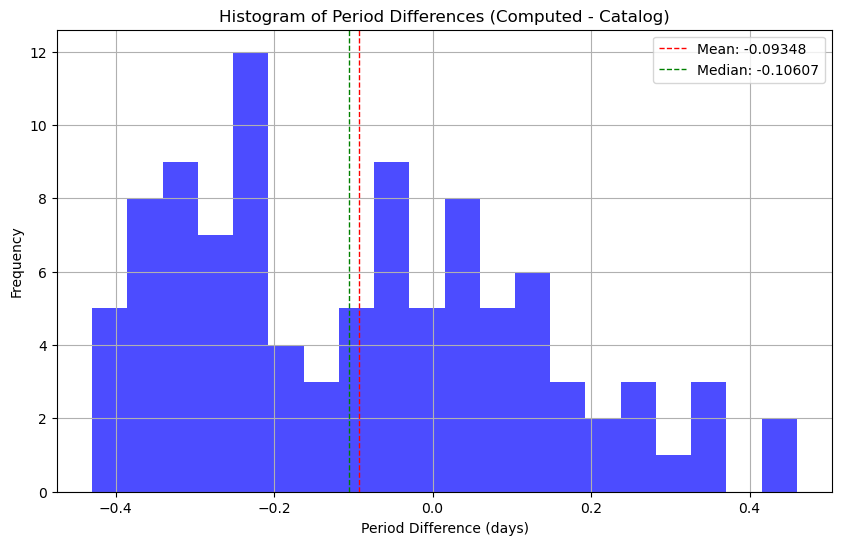

In [16]:
filtered_source_ids = [sid for sid in source_ids if sid != 4659713442253931776]
filtered_estimated_periods = [p for sid, p in zip(source_ids, estimated_periods) if sid != 4659713442253931776]

comparison_df = pd.DataFrame({
    'source_id': filtered_source_ids,
    'computed_period': filtered_estimated_periods
})


comparison_df = comparison_df.merge(rr_lyrae_df[['SOURCE_ID', 'pf']],
                                    left_on='source_id', right_on='SOURCE_ID', how='inner')
comparison_df['period_difference'] = comparison_df['computed_period'] - comparison_df['pf']

mean_difference = np.mean(comparison_df['period_difference'])
median_difference = np.median(comparison_df['period_difference'])
std_difference = np.std(comparison_df['period_difference'])
max_difference = np.max(np.abs(comparison_df['period_difference']))

print(f"Mean Period Difference: {mean_difference:.5f} days")
print(f"Median Period Difference: {median_difference:.5f} days")
print(f"Standard Deviation of Period Differences: {std_difference:.5f} days")
print(f"Absolute Max Preiod Difference: {max_difference:.5f} days")

plt.figure(figsize=(10, 6))
plt.hist(comparison_df['period_difference'], bins=20, color='blue', alpha=0.7)
plt.axvline(mean_difference, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_difference:.5f}')
plt.axvline(median_difference, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_difference:.5f}')
plt.title('Histogram of Period Differences (Computed - Catalog)')
plt.xlabel('Period Difference (days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


#### Fourier Series Representation of a Periodic Function

Any periodic, smooth function \( f(t) \) can be represented as a Fourier series:

\$
f(t) = A_0 + \sum_{k=1}^{K} \left[ a_k \sin(k \omega t) + b_k \cos(k \omega t) \right]
\$

where:

- \$ A_0 \$ is the constant term (mean magnitude),
- \$ a_k \$ and \$ b_k \$ are the Fourier coefficients for sine and cosine terms respectively,
- \$ \omega = \frac{2\pi}{P} \$ is the angular frequency with \( P \) being the known period,
- \$ K \$ is the number of terms in the Fourier expansion (typically small, like \$ K = 5 \$ or \$ K = 10 \$).

##### Recasting the Problem as Linear Algebra

Given that  $\omega$  is known from a periodogram or previous analysis, the problem of determining the constants $A_0$, $a_k$, $b_k$ (i.e., the unknown Fourier coefficients) becomes a linear algebra problem.

We aim to solve for the unknown parameters using the observed magnitudes $m_G(t)$ at different time points $t$. 

This can be written in the linear algebra form:

\$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta}
\$

where:

- \$ \mathbf{y} \$ is an array of the observed magnitudes at different times, i.e., $\mathbf{y} = [f(t_1), f(t_2), \dots, f(t_n)]^T \$,
- \$ \boldsymbol{\beta} \$ is the vector of unknown parameters (the Fourier coefficients),
  \$
  \boldsymbol{\beta} = [A_0, a_1, b_1, a_2, b_2, \dots, a_K, b_K]^T
  \$
- \$ \mathbf{X} \$ is a matrix that depends on the known times \$ t_1, t_2, \dots, t_n \$ and the angular frequency \$ \omega \$.

Specifically, the matrix \$ \mathbf{X} \$ is constructed as:
\begin{bmatrix}
1 & \sin(\omega t_1) & \cos(\omega t_1) & \sin(2\omega t_1) & \cos(2\omega t_1) & \dots & \sin(K\omega t_1) & \cos(K\omega t_1) \\
1 & \sin(\omega t_2) & \cos(\omega t_2) & \sin(2\omega t_2) & \cos(2\omega t_2) & \dots & \sin(K\omega t_2) & \cos(K\omega t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
1 & \sin(\omega t_n) & \cos(\omega t_n) & \sin(2\omega t_n) & \cos(2\omega t_n) & \dots & \sin(K\omega t_n) & \cos(K\omega t_n)
\end{bmatrix}

Each row corresponds to an observation time \$ t_i \$, and the columns consist of the constant term \$ 1 \$, followed by sine and cosine terms for increasing multiples of the angular frequency \$ \omega \$, up to the \$ K \$-th harmonic.


In [17]:
target_id = 4659713442253931776
period = rr_lyrae_df.loc[rr_lyrae_df['SOURCE_ID'] == target_id, 'pf'].values[0]
print(f"Period: {period:.5f} days")

datalink_key = next(key for key in datalink.keys() if str(target_id) in key)
light_curve_data = datalink[datalink_key][0].to_table()

time = np.array(light_curve_data['time'])
flux = np.array(light_curve_data['flux'])
flux_error = np.array(light_curve_data['flux_error'])

valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
time, flux, flux_error = time[valid_mask], flux[valid_mask], flux_error[valid_mask]

phases = (time % period) / period
sorted_indices = np.argsort(phases)
phases, flux, flux_error = phases[sorted_indices], flux[sorted_indices], flux_error[sorted_indices]

Period: 0.60501 days


In [18]:
clipped_flux = sigma_clip(flux, sigma=3, maxiters=5)  # Adjust sigma and iterations if needed

valid_mask = ~clipped_flux.mask  
phases = phases[valid_mask]
flux = flux[valid_mask]
flux_error = flux_error[valid_mask]

sorted_indices = np.argsort(phases)
phases, flux, flux_error = phases[sorted_indices], flux[sorted_indices], flux_error[sorted_indices]

def fit_fourier_series_with_offset(phases, flux, K):
    """Fit a Fourier series of degree K with a constant offset (DC term)."""
    fourier_model = models.Const1D(amplitude=np.mean(flux))

    for k in range(1, K + 1):
        # Sine term
        sine_term = models.Sine1D(amplitude=1, frequency=k, phase=0)
        sine_term.frequency.fixed = True 

        # Cosine term
        cosine_term = models.Cosine1D(amplitude=1, frequency=k, phase=0)
        cosine_term.frequency.fixed = True 

        fourier_model += sine_term + cosine_term

    fitter = fitting.LevMarLSQFitter()
    fourier_fit = fitter(fourier_model, phases, flux)

    return fourier_fit

Ks = [1, 3, 5, 7, 9]
fourier_fits = {K: fit_fourier_series_with_offset(phases, flux, K) for K in Ks}

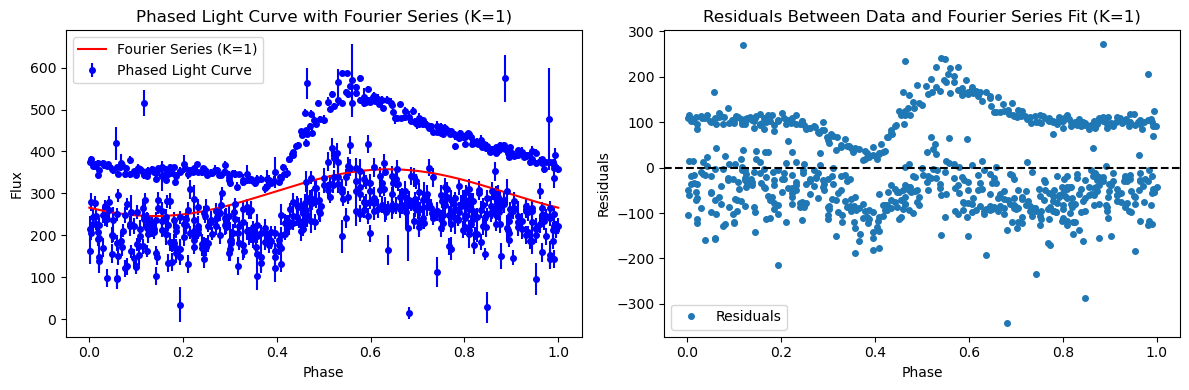

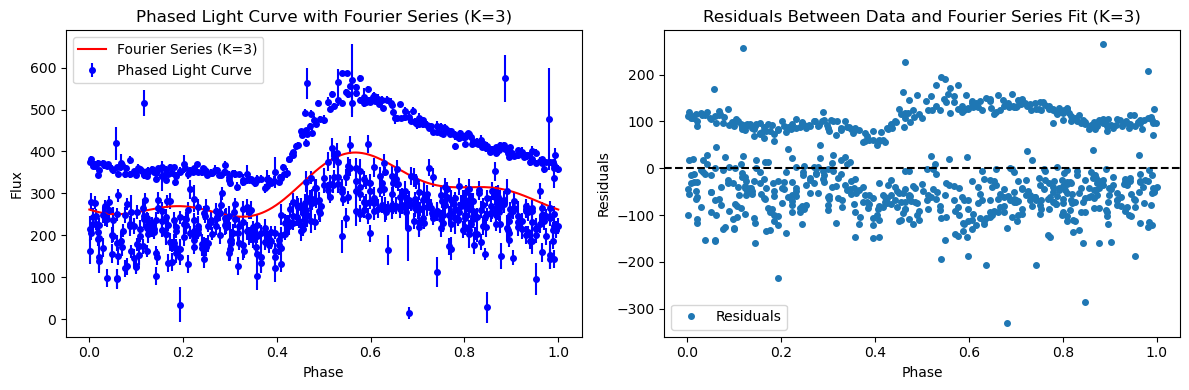

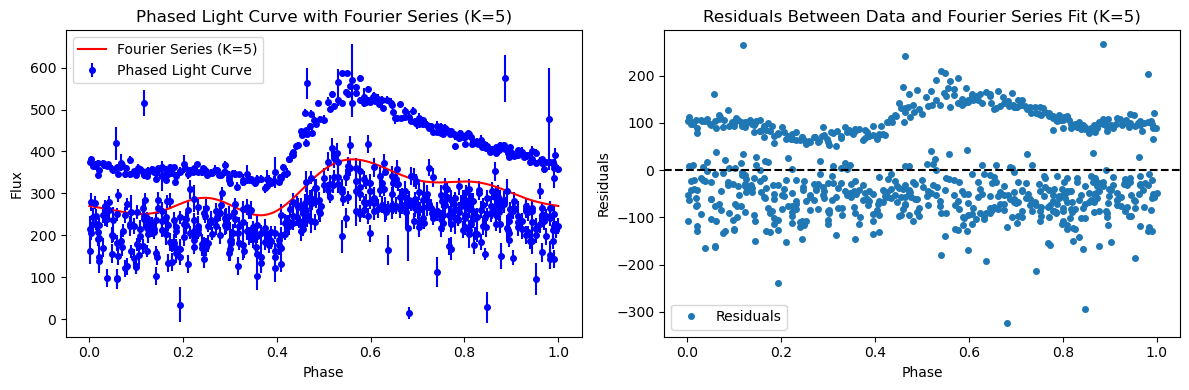

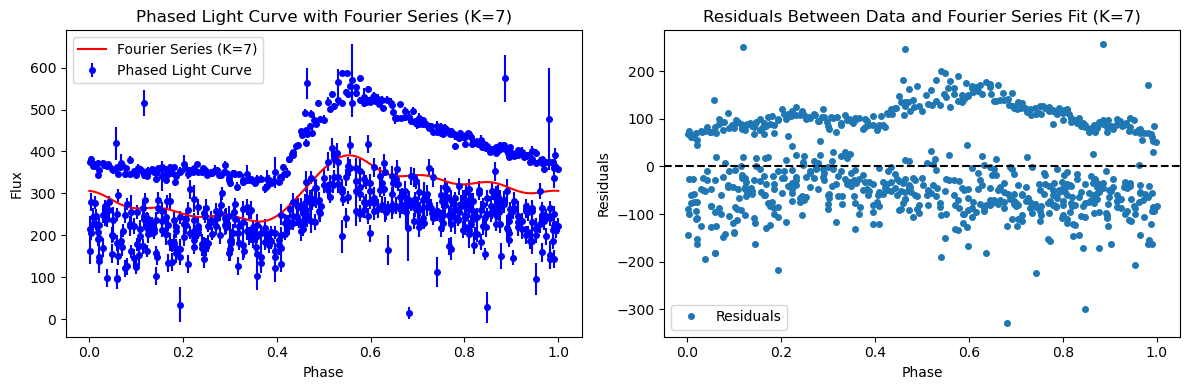

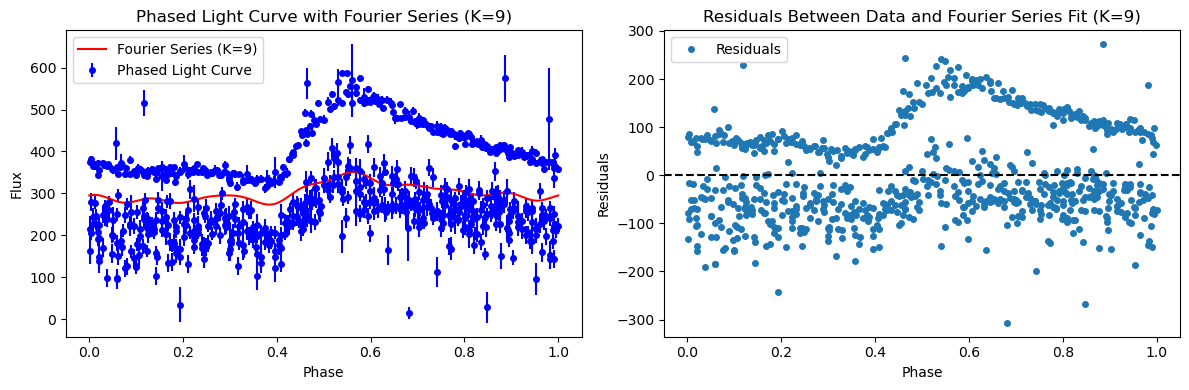

In [19]:
 Ks = [1, 3, 5, 7, 9]

for K in Ks:
    fourier_fit = fourier_fits[K]
    phase_grid = np.linspace(0, 1, 1000)
    fourier_values = fourier_fit(phase_grid)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].errorbar(phases, flux, yerr=flux_error, fmt='o', label='Phased Light Curve', markersize=4, color='blue')
    axes[0].plot(phase_grid, fourier_values, label=f'Fourier Series (K={K})', color='red')
    axes[0].set_xlabel('Phase')
    axes[0].set_ylabel('Flux')
    axes[0].set_title(f'Phased Light Curve with Fourier Series (K={K})')
    axes[0].legend()
    fitted_flux = fourier_fit(phases)
    residuals = flux - fitted_flux
    axes[1].plot(phases, residuals, 'o', label='Residuals', markersize=4)
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_xlabel('Phase')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'Residuals Between Data and Fourier Series Fit (K={K})')
    axes[1].legend()
    plt.tight_layout()
    plt.show()


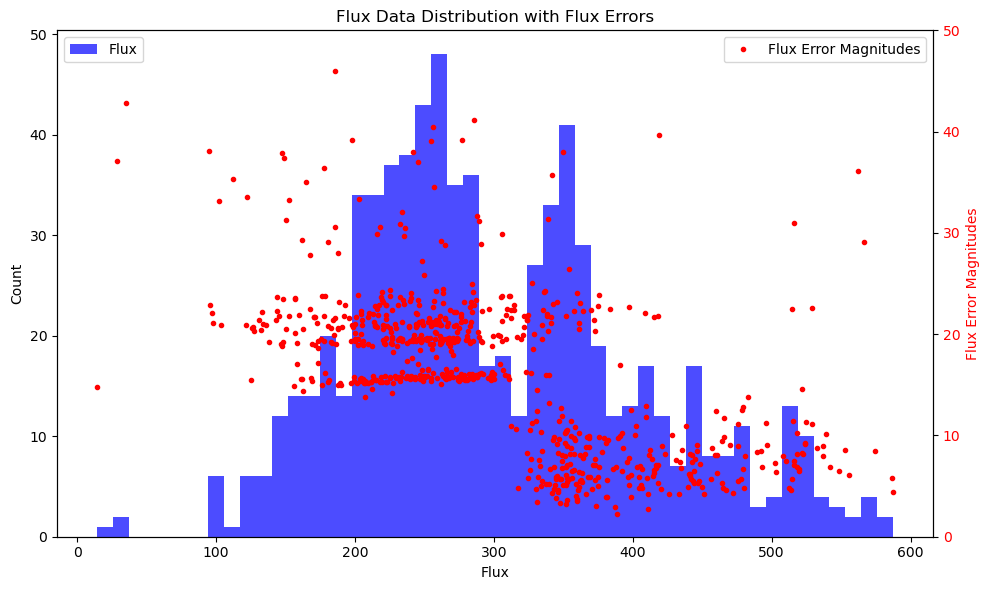

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(flux, bins=50, alpha=0.7, color='blue', label='Flux')
ax1.set_xlabel('Flux')
ax1.set_ylabel('Count')
ax1.set_title('Flux Data Distribution with Flux Errors')

ax2 = ax1.twinx()
ax2.plot(sorted(flux), np.abs(flux_error[np.argsort(flux)]), 'r.', label='Flux Error Magnitudes')

ax2.set_ylabel('Flux Error Magnitudes', color='red')
ax2.set_ylim([0, 50])
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


As visualized by the phased light curves as well, we see that there the flux is distribution is bimodal. We also see that the error magnitudes also concentrated to a mode, with higher error magnitudes, typically ones greater than 15 concentrated to the first mode, and ones less than 15 concentratd to the second. Such may explain the rather distinct gap in measurements for the flux – it seems as though there are two graphs, albeit vertically translated, transposed onto the same axes. The bottom one, in general, has in general, higher error, as also depicted by the histogram. It is likely, that the lower cluster, then, is impacted by systematic errors.

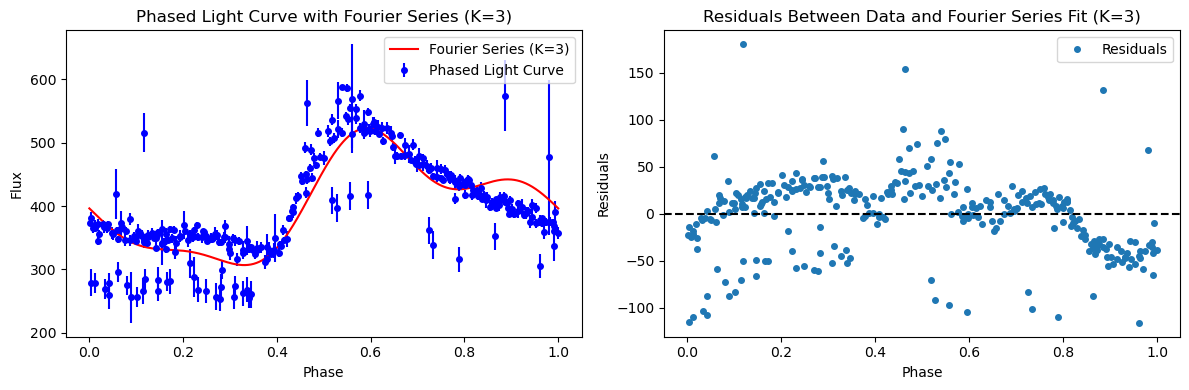

In [21]:
target_id = 4659713442253931776
period = rr_lyrae_df.loc[rr_lyrae_df['SOURCE_ID'] == target_id, 'pf'].values[0]
datalink_key = next(key for key in datalink.keys() if str(target_id) in key)
light_curve_data = datalink[datalink_key][0].to_table()
time = np.array(light_curve_data['time'])
flux = np.array(light_curve_data['flux'])
flux_error = np.array(light_curve_data['flux_error'])
valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
time, flux, flux_error = time[valid_mask], flux[valid_mask], flux_error[valid_mask]
phases = (time % period) / period
sorted_indices = np.argsort(phases)
phases, flux, flux_error = phases[sorted_indices], flux[sorted_indices], flux_error[sorted_indices]

clipped_flux = sigma_clip(flux, sigma=3, maxiters=5)
valid_mask = ~clipped_flux.mask

phases_filtered = phases[valid_mask]
flux_filtered = flux[valid_mask]
flux_error_filtered = flux_error[valid_mask]

sorted_indices_filtered = np.argsort(phases_filtered)
phases_filtered, flux_filtered, flux_error_filtered = phases_filtered[sorted_indices_filtered], flux_filtered[sorted_indices_filtered], flux_error_filtered[sorted_indices_filtered]
K = 3
fourier_fit_filtered = fit_fourier_series_with_offset(phases_filtered, flux_filtered, K)
fitted_flux_filtered = fourier_fit_filtered(phases_filtered)
mask_filtered = flux_filtered >= fitted_flux_filtered
filtered_phases = phases_filtered[mask_filtered]
filtered_flux = flux_filtered[mask_filtered]
filtered_flux_error = flux_error_filtered[mask_filtered]

filtered_data = pd.DataFrame({
    'Phase': filtered_phases,
    'Flux': filtered_flux,
    'Flux Error': filtered_flux_error
})

Ks = [3]

for K in Ks:
    fourier_fit = fit_fourier_series_with_offset(filtered_phases, filtered_flux, K)
    phase_grid = np.linspace(0, 1, 1000)
    fourier_values = fourier_fit(phase_grid)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].errorbar(filtered_phases, filtered_flux, yerr=filtered_flux_error, fmt='o', label='Phased Light Curve', markersize=4, color='blue')
    axes[0].plot(phase_grid, fourier_values, label=f'Fourier Series (K={K})', color='red')
    axes[0].set_xlabel('Phase')
    axes[0].set_ylabel('Flux')
    axes[0].set_title(f'Phased Light Curve with Fourier Series (K={K})')
    axes[0].legend()
    
    fitted_flux = fourier_fit(filtered_phases)
    residuals = filtered_flux - fitted_flux
    
    axes[1].plot(filtered_phases, residuals, 'o', label='Residuals', markersize=4)
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_xlabel('Phase')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'Residuals Between Data and Fourier Series Fit (K={K})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

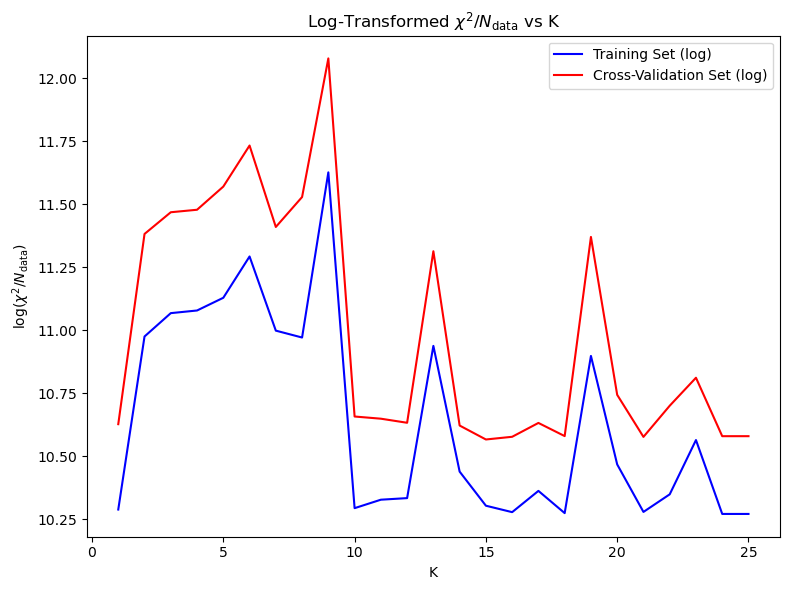

In [22]:
Ks = range(1, 26)
train_chi2 = []
val_chi2 = []

phases_train, phases_val, flux_train, flux_val, flux_err_train, flux_err_val = train_test_split(
    phases, flux, flux_error, test_size=0.2, random_state=42
)

for K in Ks:
    fourier_fit = fit_fourier_series_with_offset(phases_train, flux_train, K)  
    fitted_flux_train = fourier_fit(phases_train)
    chi2_train = np.sum(((flux_train - fitted_flux_train) / flux_err_train) ** 2) / len(flux_train)
    train_chi2.append(chi2_train)

    fitted_flux_val = fourier_fit(phases_val)
    chi2_val = np.sum(((flux_val - fitted_flux_val) / flux_err_val) ** 2) / len(flux_val)
    val_chi2.append(chi2_val)

log_train_chi2 = np.log(train_chi2)
log_val_chi2 = np.log(val_chi2)

plt.figure(figsize=(8, 6))
plt.plot(Ks, log_train_chi2, label='Training Set (log)', color='blue')
plt.plot(Ks, log_val_chi2, label='Cross-Validation Set (log)', color='red')
plt.xlabel('K')
plt.ylabel(r'$\log(\chi^2 / N_{\mathrm{data}})$')
plt.title(r'Log-Transformed $\chi^2 / N_{\mathrm{data}}$ vs K')
plt.legend()
plt.tight_layout()
plt.show()

Predicted magnitude exactly 10 days after the last data point: 239.37257


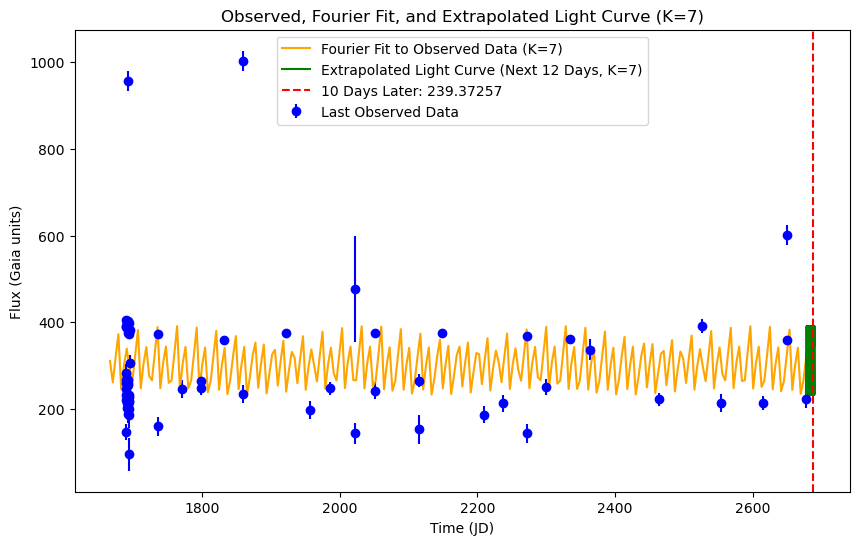

In [23]:
optimal_K = 7
fourier_fit = fourier_fits[optimal_K]

last_time = np.max(time)

extrapolation_days = np.linspace(last_time, last_time + 12, 5000)
extrapolation_phases = (extrapolation_days % period) / period  

extrapolated_flux = fourier_fit(extrapolation_phases)

time_10_days_later = last_time + 10
phase_10_days_later = (time_10_days_later % period) / period
magnitude_10_days_later = fourier_fit(phase_10_days_later)

print(f"Predicted magnitude exactly 10 days after the last data point: {magnitude_10_days_later:.5f}")

fine_time_grid = np.linspace(np.min(time), last_time, 250) 
fine_phases = (fine_time_grid % period) / period  

plt.figure(figsize=(10, 6))

plt.errorbar(time[-75:], flux[-75:], yerr=flux_error[-75:], fmt='o', label='Last Observed Data', color='blue')

fitted_flux_fine = fourier_fit(fine_phases)
plt.plot(fine_time_grid, fitted_flux_fine, label=f'Fourier Fit to Observed Data (K={optimal_K})', color='orange')

plt.plot(extrapolation_days, extrapolated_flux, label=f'Extrapolated Light Curve (Next 12 Days, K={optimal_K})', color='green')

plt.axvline(time_10_days_later, color='red', linestyle='--', label=f'10 Days Later: {magnitude_10_days_later:.5f}')

plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title(f'Observed, Fourier Fit, and Extrapolated Light Curve (K={optimal_K})')
plt.legend()
plt.show()


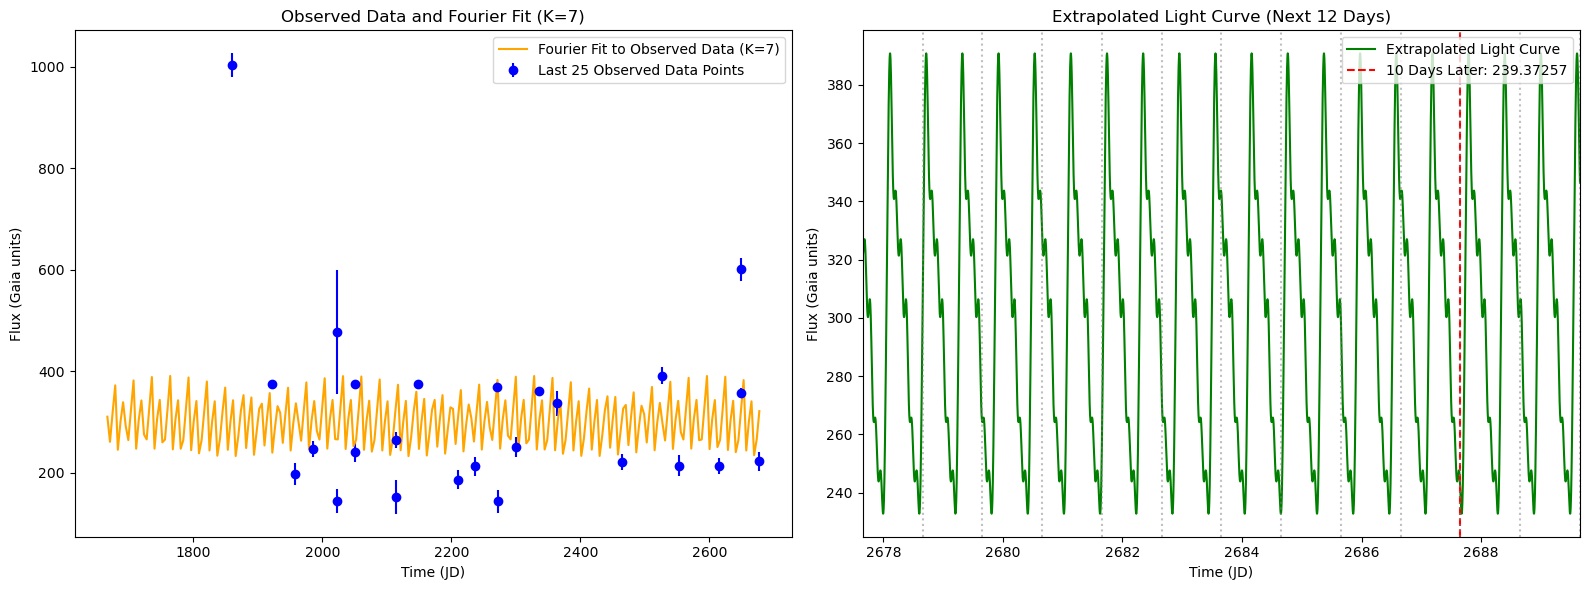

In [24]:
fitted_flux_fine = fourier_fit(fine_phases)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.errorbar(time[-25:], flux[-25:], yerr=flux_error[-25:], fmt='o', label='Last 25 Observed Data Points', color='blue')
plt.plot(fine_time_grid, fitted_flux_fine, label=f'Fourier Fit to Observed Data (K={optimal_K})', color='orange')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title(f'Observed Data and Fourier Fit (K={optimal_K})')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(extrapolation_days, extrapolated_flux, label='Extrapolated Light Curve', color='green')
plt.axvline(time_10_days_later, color='red', linestyle='--', label=f'10 Days Later: {magnitude_10_days_later:.5f}')
for day in range(1, 13):
    plt.axvline(last_time + day, color='gray', linestyle=':', alpha=0.5)

plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title('Extrapolated Light Curve (Next 12 Days)')
plt.xlim(last_time, last_time + 12)  # Zoom in on extrapolated data
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
def calculate_mean_flux_from_fourier(fourier_fit, phase_grid):
    fitted_flux = fourier_fit(phase_grid)
    mean_flux = np.mean(fitted_flux)
    return mean_flux

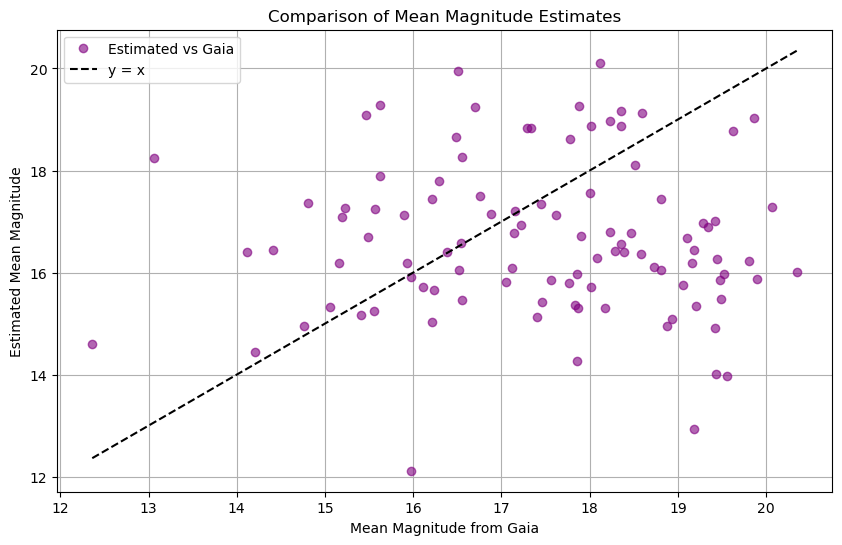

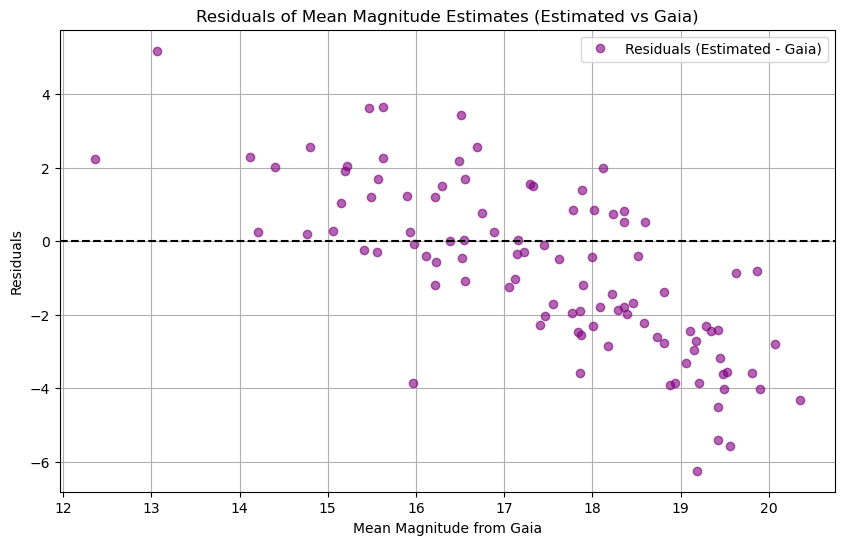

In [26]:
mean_magnitudes = []
mean_magnitude_errors = []
mean_magnitudes_gaia = rr_lyrae_df['int_average_g'].values 
phase_grid = np.linspace(0, 1, 1000)

for idx, dl_key in enumerate(dl_keys):
    light_curve_data = datalink[dl_key][0].to_table()
    time = light_curve_data['time']
    flux = light_curve_data['flux']  # Flux in electron/s
    flux_error = light_curve_data['flux_error']
    if hasattr(light_curve_data['mag'], 'unit'):
        mag = light_curve_data['mag']
    else:
        mag = light_curve_data['mag'] * u.mag

    valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
    time = time[valid_mask]
    mag = mag[valid_mask]
    flux = flux[valid_mask]
    flux_error = flux_error[valid_mask]

    if len(time) < 2:
        print(f"Light curve {idx+1}: Not enough valid data points after filtering.")
        continue

    mag_err = (2.5 / np.log(10)) * (flux_error / flux)
    mag_err = mag_err * u.mag

    flux_linear = 10**(-0.4 * mag.value)
    flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5

    # Calculate mean magnitude once
    mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
    mean_magnitudes.append(mean_mag)
    mean_magnitude_errors.append(mean_mag_err)

# Plot comparison of mean magnitudes
plt.figure(figsize=(10, 6))
plt.plot(mean_magnitudes_gaia, mean_magnitudes, 'o', label="Estimated vs Gaia", color='purple', alpha=0.6)
plt.plot([min(mean_magnitudes_gaia), max(mean_magnitudes_gaia)], 
         [min(mean_magnitudes_gaia), max(mean_magnitudes_gaia)], 
         linestyle='--', color='black', label='y = x')
plt.xlabel('Mean Magnitude from Gaia')
plt.ylabel('Estimated Mean Magnitude')
plt.title('Comparison of Mean Magnitude Estimates')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals with lower opacity
plt.figure(figsize=(10, 6))
residuals = np.array(mean_magnitudes) - mean_magnitudes_gaia
plt.plot(mean_magnitudes_gaia, residuals, 'o', label="Residuals (Estimated - Gaia)", color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Mean Magnitude from Gaia')
plt.ylabel('Residuals')
plt.title('Residuals of Mean Magnitude Estimates (Estimated vs Gaia)')
plt.legend()
plt.grid(True)
plt.show()


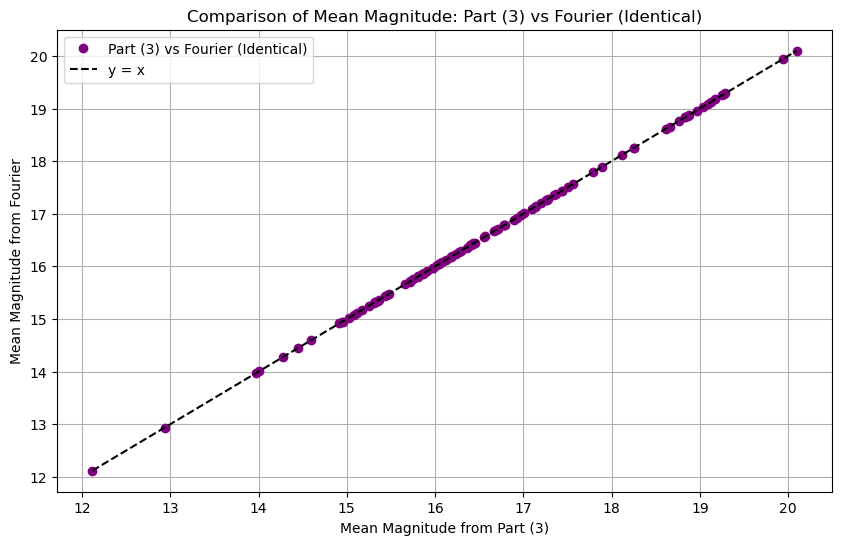

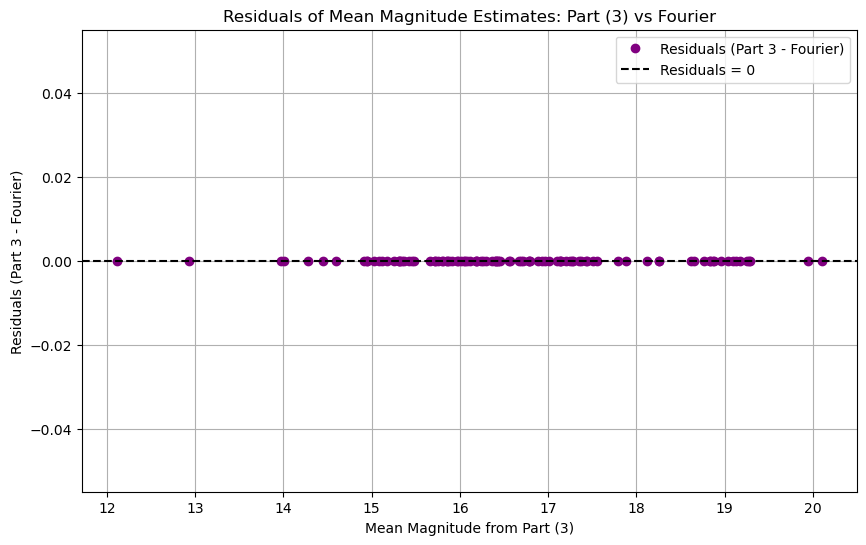

In [27]:
# Plot comparison of mean magnitudes: Part (3) vs Fourier (identical values)
plt.figure(figsize=(10, 6))
plt.plot(mean_magnitudes, mean_magnitudes, 'o', color='purple', label="Part (3) vs Fourier (Identical)")
plt.plot([min(mean_magnitudes), max(mean_magnitudes)],
         [min(mean_magnitudes), max(mean_magnitudes)], 
         linestyle='--', color='black', label='y = x')  # All points should lie on this line
plt.xlabel('Mean Magnitude from Part (3)')
plt.ylabel('Mean Magnitude from Fourier')
plt.title('Comparison of Mean Magnitude: Part (3) vs Fourier (Identical)')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals: Part (3) - Fourier (should all be zero)
plt.figure(figsize=(10, 6))
residuals = np.zeros_like(mean_magnitudes)  # Since Part 3 and Fourier are identical
plt.plot(mean_magnitudes, residuals, 'o', color='purple', label="Residuals (Part 3 - Fourier)")
plt.axhline(0, color='black', linestyle='--', label="Residuals = 0")  # All residuals are 0
plt.xlabel('Mean Magnitude from Part (3)')
plt.ylabel('Residuals (Part 3 - Fourier)')
plt.title('Residuals of Mean Magnitude Estimates: Part (3) vs Fourier')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
import time

query_rrc = """
SELECT TOP 3 *
FROM gaiadr3.vari_rrlyrae
WHERE best_classification = 'RRc'
AND int_average_g < 15
AND num_clean_epochs_g > 80
"""

query_rrab = """
SELECT TOP 3 *
FROM gaiadr3.vari_rrlyrae
WHERE best_classification = 'RRab'
AND int_average_g < 15
AND num_clean_epochs_g > 80
"""

rr_lyrae_df_rrc = get_and_parse_cached_gaia_query(query_rrc, "rrlyrae_rrc_data.csv", verbose=True, overwrite=False)
rr_lyrae_df_rrab = get_and_parse_cached_gaia_query(query_rrab, "rrlyrae_rrab_data.csv", verbose=True, overwrite=False)

Reading the file rrlyrae_rrc_data.csv from disk
  Total time: 0.0136 sec
Reading the file rrlyrae_rrab_data.csv from disk
  Total time: 0.00256 sec


In [63]:
def fit_fourier_series_with_offset(phases, magnitudes, K):
    fourier_model = models.Const1D(amplitude=np.mean(magnitudes))
    for k in range(1, K + 1):
        fourier_model += models.Sine1D(amplitude=1.0, frequency=k) + models.Cosine1D(amplitude=1.0, frequency=k)
    fitter = fitting.LevMarLSQFitter()
    sorted_indices = np.argsort(phases)
    phases_sorted = phases[sorted_indices]
    magnitudes_sorted = magnitudes[sorted_indices]
    fourier_fit = fitter(fourier_model, phases_sorted, magnitudes_sorted)
    return fourier_fit, phases_sorted, magnitudes_sorted

def get_light_curve(source_id):
    retrieval_type = 'EPOCH_PHOTOMETRY'
    data_structure = 'INDIVIDUAL'
    data_release = 'Gaia DR3'
    format_type = 'votable'
    
    datalink = Gaia.load_data(ids=[source_id], data_release=data_release, 
                              retrieval_type=retrieval_type, data_structure=data_structure, 
                              verbose=False, output_file=None, format=format_type)
    return datalink


def process_light_curves(source_ids, num_terms, classification):
    fig, axes = plt.subplots(1, len(source_ids), figsize=(5 * len(source_ids), 5), sharey=True)
    if len(source_ids) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, source_id in zip(axes, source_ids):
        try:
            datalink = get_light_curve(source_id)
            light_curve_data = datalink[f'EPOCH_PHOTOMETRY-Gaia DR3 {source_id}.xml'][0].to_table()

            time_data = light_curve_data['time']
            flux = light_curve_data['flux']
            flux_error = light_curve_data['flux_error']
            if hasattr(light_curve_data['mag'], 'unit'):
                mag = light_curve_data['mag']
            else:
                mag = light_curve_data['mag'] * u.mag
            valid_mask = np.isfinite(time_data) & np.isfinite(flux) & np.isfinite(flux_error) & np.isfinite(mag)
            time_filtered = time_data[valid_mask]
            mag_filtered = mag[valid_mask]
            flux_filtered = flux[valid_mask]
            flux_error_filtered = flux_error[valid_mask]

            if len(time_filtered) < 2:
                print(f"Light curve for source {source_id}: Not enough valid data points after filtering.")
                ax.set_visible(False)
                continue

            mag_err = (2.5 / np.log(10)) * (flux_error_filtered / flux_filtered)
            mag_err = mag_err * u.mag

            if isinstance(time_filtered, u.Quantity):
                time_days = time_filtered.to(u.day).value
            else:
                time_days = np.array(time_filtered)

            best_period, frequency, power = estimate_period_lombscargle(time_days, mag_filtered.value, mag_err.value)
            flux_linear = 10 ** (-0.4 * mag_filtered.value)
            flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5
            mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
            phases = (time_days % best_period) / best_period
            fourier_fit, phases_sorted, mag_sorted = fit_fourier_series_with_offset(phases, mag_filtered.value, num_terms)
            phase_dense = np.linspace(0, 1, 1000)
            model_mag_dense = fourier_fit(phase_dense)
            sorted_indices = np.argsort(phases)
            sorted_err = mag_err.value[sorted_indices]

            ax.errorbar(phases_sorted, mag_sorted, yerr=sorted_err, fmt='.', label='Data', alpha=0.6)
            ax.plot(phase_dense, model_mag_dense, 'r-', label='Fourier Fit')
            ax.set_xlabel('Phase')
            if ax.is_first_col():
                ax.set_ylabel('G-band Magnitude')
            ax.set_title(f'Source ID: {source_id}\nPeriod: {best_period:.3f} days')
            ax.invert_yaxis()  
            ax.legend()

            print(f"Source ID: {source_id}")
            print(f"Estimated Period: {best_period:.3f} days")
            print(f"Mean G-band Magnitude: {mean_mag:.3f} ± {mean_mag_err:.3f}")

        except Exception as e:
            print(f"An error occurred while processing source {source_id}: {e}")
            ax.set_visible(False)
            continue

    fig.suptitle(f'Phased Light Curves with Fourier Models for {classification} RR Lyrae', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def comparative_plot(rrc_ids, rrab_ids, num_terms):
    total = len(rrc_ids) + len(rrab_ids)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()

    for idx, (source_id, classification) in enumerate(zip(list(rrc_ids) + list(rrab_ids), ['RRc']*len(rrc_ids) + ['RRab']*len(rrab_ids))):
        ax = axes[idx]
        try:
            datalink = get_light_curve(source_id)
            light_curve_data = datalink[f'EPOCH_PHOTOMETRY-Gaia DR3 {source_id}.xml'][0].to_table()

            time_data = light_curve_data['time']
            flux = light_curve_data['flux']
            flux_error = light_curve_data['flux_error']

            if hasattr(light_curve_data['mag'], 'unit'):
                mag = light_curve_data['mag']
            else:
                mag = light_curve_data['mag'] * u.mag

            valid_mask = np.isfinite(time_data) & np.isfinite(flux) & np.isfinite(flux_error) & np.isfinite(mag)
            time_filtered = time_data[valid_mask]
            mag_filtered = mag[valid_mask]
            flux_filtered = flux[valid_mask]
            flux_error_filtered = flux_error[valid_mask]

            if len(time_filtered) < 2:
                print(f"Light curve for source {source_id}: Not enough valid data points after filtering.")
                ax.set_visible(False)
                continue

            mag_err = (2.5 / np.log(10)) * (flux_error_filtered / flux_filtered)
            mag_err = mag_err * u.mag

            if isinstance(time_filtered, u.Quantity):
                time_days = time_filtered.to(u.day).value
            else:
                time_days = np.array(time_filtered)

            best_period, frequency, power = estimate_period_lombscargle(time_days, mag_filtered.value, mag_err.value)
            flux_linear = 10 ** (-0.4 * mag_filtered.value)
            flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5
            mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
            phases = (time_days % best_period) / best_period
            fourier_fit, phases_sorted, mag_sorted = fit_fourier_series_with_offset(phases, mag_filtered.value, num_terms)
            phase_dense = np.linspace(0, 1, 1000)
            model_mag_dense = fourier_fit(phase_dense)
            sorted_indices = np.argsort(phases)
            sorted_err = mag_err.value[sorted_indices]
            ax.errorbar(phases_sorted, mag_sorted, yerr=sorted_err, fmt='.', label='Data', alpha=0.6)
            ax.plot(phase_dense, model_mag_dense, 'r-', label='Fourier Fit')
            ax.set_xlabel('Phase')
            if idx < 3:
                ax.set_ylabel('G-band Magnitude')
            ax.set_title(f'{classification} | ID: {source_id}\nPeriod: {best_period:.3f} days')
            ax.invert_yaxis()  # Magnitude scale: lower is brighter
            ax.legend()

        except Exception as e:
            print(f"An error occurred while processing source {source_id}: {e}")
            ax.set_visible(False)
            continue

    fig.suptitle('Comparative Phased Light Curves for RRc and RRab RR Lyrae Stars', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

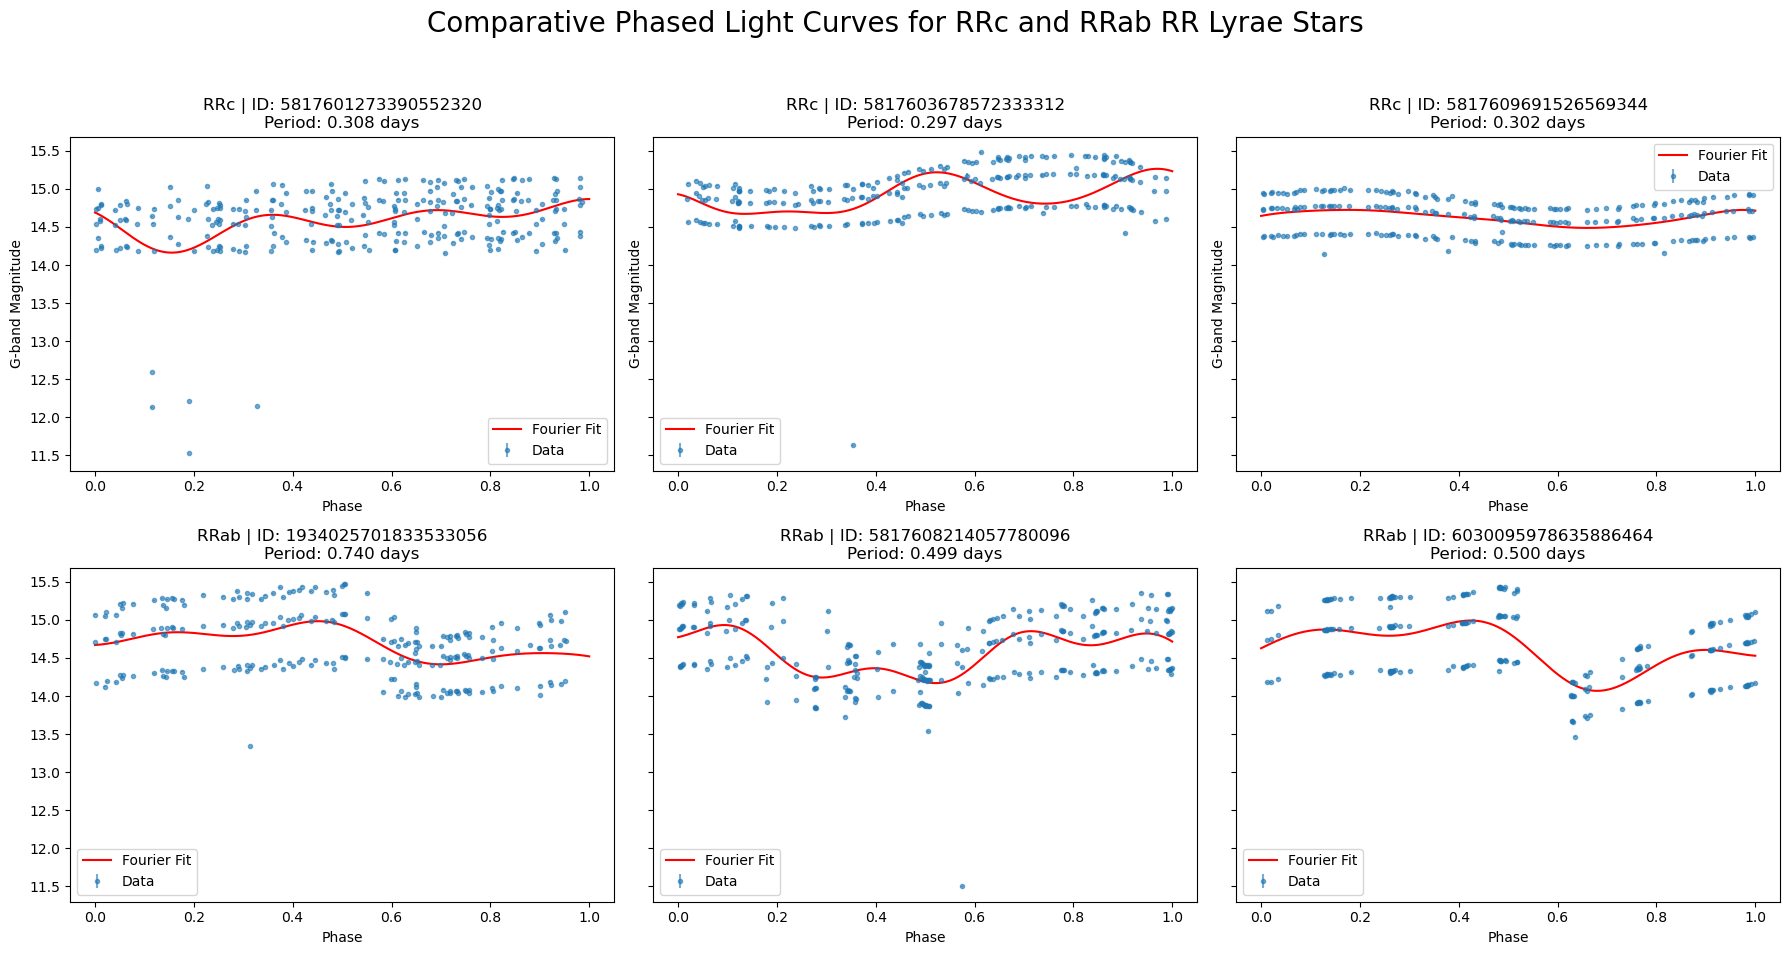

In [64]:
num_terms = 3
rrc_source_ids = rr_lyrae_df_rrc['SOURCE_ID']
rrab_source_ids = rr_lyrae_df_rrab['SOURCE_ID']
comparative_plot(rrc_source_ids, rrab_source_ids, num_terms)


#### Comparison of RRc and RRab Phased Light Curves

##### Visual Comparison of the Light Curves:

1. **RRc Light Curves (Top Row)**:
   - The RRc light curves are from stars that generally have shorter periods, around 0.3 days. These light curves exhibit smaller amplitude variations and a more sinusoidal, smoother shape.
   - The curves lack sharp features, showing a relatively smooth rise and fall in brightness, which is characteristic of first-overtone pulsations.
   - The overall variations in brightness are less dramatic when compared to the RRab stars.

2. **RRab Light Curves (Bottom Row)**:
   - The RRab light curves correspond to stars with longer periods, generally above 0.4 days. These light curves have a more "sawtooth" or asymmetric appearance.
   - There is a sharper rise to the maximum brightness and a slower, more gradual decline afterward, indicative of fundamental-mode pulsations.
   - The amplitude of the variations in brightness is more significant in RRab stars, with a distinct, noticeable peak followed by a slower descent.

##### Key Differences Between RRc and RRab Light Curves:

- **Period and Mode of Pulsation**:
   - **RRc stars** pulsate in the first overtone mode and have shorter periods (typically < 0.4 days). Their light curves are more sinusoidal and smoother.
   - **RRab stars** pulsate in the fundamental mode, leading to longer periods (generally > 0.4 days). Their light curves have a steeper ascent to peak brightness and a slower decline, creating a more asymmetrical, sawtooth shape.

- **Amplitude**:
   - **RRc stars** have smaller amplitude variations in their brightness, indicating less energetic pulsations.
   - **RRab stars** exhibit larger amplitude changes, which correspond to more energetic pulsations.

##### Insights from Literature:
- **RRc stars** are typically bluer and hotter than RRab stars, as they pulsate in the first overtone mode. The pulsations are less pronounced, resulting in the smoother light curve appearance.
- **RRab stars**, pulsating in the fundamental mode, often exhibit larger changes in radius and temperature during their pulsation cycles, hence the more pronounced sawtooth shape of their light curves.
- The sharp rise in brightness seen in RRab light curves is linked to the rapid contraction of the star, followed by a slower expansion, which explains the asymmetry.


#### Evidence of Intrinsic Scatter in RR Lyrae Light Curves

Based on the plot of the phased light curves and findings from Netzel et al. (2018), there is evidence of **intrinsic scatter** in some of the light curves, suggesting that they are not perfectly described by a single period.

##### Observations:
- The scatter present in the RRab light curves, particularly around peak brightness, hints at potential deviations from simple periodicity.
- This intrinsic scatter could be indicative of phenomena such as the **Blazhko effect**, which is known to cause quasi-periodic modulation of the amplitude and phase of RR Lyrae stars' pulsations. According to Netzel et al. (2018), the Blazhko effect manifests as variations that can be seen as **multiplets** or **triplets** in the frequency domain centered around the main pulsation frequency.

##### Insights from Netzel et al. (2018):
- The study found that the **Blazhko effect** is present in about 5.6% of RRc stars and a higher percentage of RRab stars (exceeding 50% in some cases).
- **Period doubling** and multiperiodic modulation are also observed in some RR Lyrae stars, which could explain the deviations in the light curves.

The deviations you observe could be a result of this modulation, especially if the light curves display additional side frequencies in their power spectra, indicative of the Blazhko effect. You may consider performing a more detailed analysis of the frequency spectrum of each star to determine if any such modulations are present.

##### Conclusion:
The intrinsic scatter seen in the plotted light curves could likely be attributed to deviations from simple periodicity, as discussed by Netzel et al. (2018), including modulation effects like the Blazhko effect. The light curves are not perfectly described by a single period due to these phenomena.


#### Minimizing the Effects of Interstellar Dust for Accurate Absolute Magnitude Estimations of RR Lyrae Stars Using Gaia Distances

##### Interstellar Extinction:
- **Dust Absorption**: Dust particles in the interstellar medium absorb and scatter light from stars, causing them to appear dimmer than they intrinsically are.
- **Reddening**: The scattering process is wavelength-dependent, making stars appear redder. This effect alters the observed colors and magnitudes of stars.

##### Impact on Distance and Luminosity Measurements:
- **Distance Estimation**: Gaia measures parallax to estimate distances. However, if a star appears dimmer due to dust, it might be incorrectly inferred to be farther away than it actually is.
- **Absolute Magnitude Calculation**: Absolute magnitude is derived from the apparent magnitude and distance. Dust-induced dimming leads to underestimation of a star's true brightness.

##### Importance of High Galactic Latitude Selection:
By selecting RR Lyrae stars that lie above or below the Galactic disk (i.e., at high Galactic latitudes), we ensure that their light traverses less interstellar dust, leading to more accurate absolute magnitude estimations. This is essential for establishing a reliable period-luminosity (P-L) relation, which is fundamental for using RR Lyrae stars as standard candles in distance measurements across the universe.


In [60]:
query_rr_lyrae = """
SELECT DISTINCT
    vr.source_id,
    vr.best_classification,
    vr.int_average_g,
    vr.num_clean_epochs_g,
    gs.ra AS ra_column,
    gs.dec AS dec_column,
    gs.b AS b_column,
    (1000.0 / gs.parallax) AS distance_pc, 
    vr.pf AS period,  -- Fundamental period (pf) for the RR Lyrae stars
    gs.phot_g_mean_mag AS g_mag,  
    gs.ruwe AS uwe,  -- Renormalized Unit Weight Error (RUWE)
    gs.phot_bp_mean_mag - gs.phot_rp_mean_mag AS gbp_minus_grp, 
    gs.phot_bp_mean_flux / gs.phot_rp_mean_flux AS excess_ratio,
    gs.phot_g_mean_flux AS flux,  
    gs.phot_g_mean_flux_error AS flux_err 
FROM
    gaiadr3.vari_rrlyrae AS vr
JOIN
    gaiadr3.gaia_source AS gs
    ON vr.source_id = gs.source_id
WHERE
    -- (a) Parallax error less than 20% of parallax
    (gs.parallax_error / gs.parallax) < 0.2
    AND
    -- (b) Absolute Galactic latitude greater than 30 degrees
    ABS(gs.b) > 30
    AND
    -- (c) Distance less than 4000 parsecs (4 kpc)
    (1000.0 / gs.parallax) < 4000
    AND
    -- (d) Parallax is positive to ensure valid distance
    gs.parallax > 0
    AND
    -- (e) Ensure the period (pf) is not null
    vr.pf IS NOT NULL
"""

rrlyrae_gaia_joined_data_df = get_and_parse_cached_gaia_query(query_rr_lyrae, "rrlyrae_gaia_joined_data.csv", verbose=True, overwrite=True)
rrlyrae_gaia_joined_data_df.head(10)

Wrote the file rrlyrae_gaia_joined_data.csv to disk
  Total time: 2.95 sec


,SOURCE_ID,best_classification,int_average_g,num_clean_epochs_g,ra_column,dec_column,b_column,distance_pc,period,g_mag,uwe,gbp_minus_grp,excess_ratio,flux,flux_err
0,20161096179157248,RRab,13.193645,23,39.734959,8.742438,-45.670389,3049.142647,0.604292,13.282271,1.268560,0.791913,0.830794,9.163009e+04,1418.689941
1,23769177945357440,RRab,12.668458,27,34.967989,9.279951,-47.750749,2281.488958,0.462676,12.633805,1.255683,0.552656,1.035610,1.665040e+05,2404.699219
2,34113623857898880,RRab,11.630653,20,44.591489,15.671683,-37.274806,1450.902575,0.642411,11.653530,0.874543,0.860866,0.779673,4.107094e+05,3339.396973
3,97876875839666944,RRab,20.251863,20,30.017074,22.796903,-37.392695,177.349787,0.541656,20.453583,1.101253,2.875082,0.121962,1.240262e+02,1.077544
4,294072906063827072,RRab,10.107671,34,18.608950,24.415476,-38.158603,801.489517,0.390316,10.129585,1.534082,0.533829,1.053724,1.671524e+06,13424.774414
5,297095016852854400,RRab,20.296398,30,21.774006,29.201349,-33.026736,265.418702,0.407552,20.319414,1.152785,2.244843,0.217932,1.403399e+02,1.118338
6,308108245007332224,RRab,13.884679,38,17.588538,28.550090,-34.137230,3713.565451,0.382126,14.083345,1.332993,0.737883,0.873184,4.381355e+04,739.641418
7,580348453620559360,RRab,12.555153,33,136.202403,5.502315,32.049340,1929.197678,0.496833,12.576814,3.121423,0.558371,1.030174,1.754775e+05,1825.245117
8,584371601026374272,RRab,12.259682,64,133.722906,6.436825,30.318022,1990.756439,0.636424,12.292535,1.004501,0.665476,0.933401,2.279990e+05,1306.413452
9,586254622063844736,RRab,12.420674,55,142.608904,7.205749,38.446745,2419.182119,0.602851,12.468440,1.276847,0.668055,0.931187,1.938968e+05,1630.662720


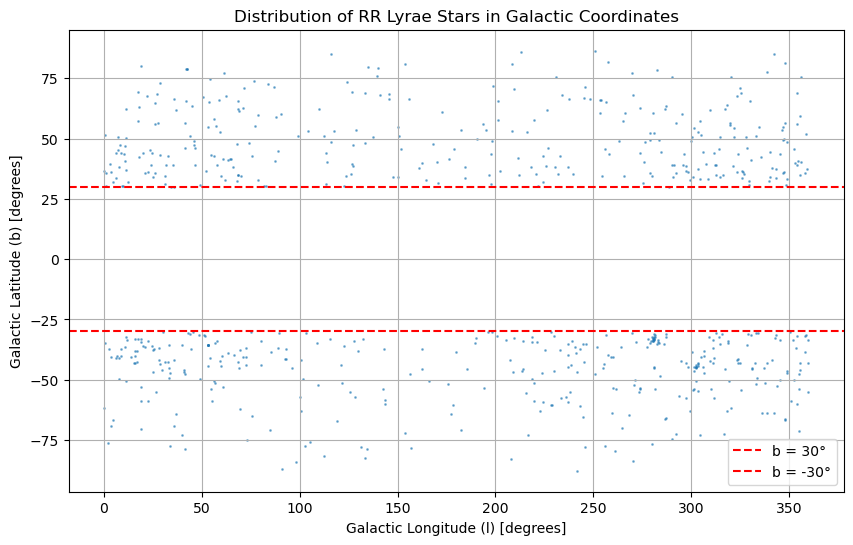

Number of stars with |b| < 30 degrees: 0


In [65]:
rrlyrae_gaia_joined_data_df = pd.read_csv("rrlyrae_gaia_joined_data.csv")
ra = rrlyrae_gaia_joined_data_df['ra_column'].values
dec = rrlyrae_gaia_joined_data_df['dec_column'].values
distance = rrlyrae_gaia_joined_data_df['distance_pc'].values
coords_icrs = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, distance=distance * u.pc, frame='icrs')
coords_galactic = coords_icrs.galactic
l = coords_galactic.l.degree  # Galactic longitude
b = coords_galactic.b.degree  # Galactic latitude

plt.figure(figsize=(10, 6))
plt.scatter(l, b, s=1, alpha=0.5)
plt.title('Distribution of RR Lyrae Stars in Galactic Coordinates')
plt.xlabel('Galactic Longitude (l) [degrees]')
plt.ylabel('Galactic Latitude (b) [degrees]')
plt.grid(True)
plt.axhline(y=30, color='r', linestyle='--', label='b = 30°')
plt.axhline(y=-30, color='r', linestyle='--', label='b = -30°')
plt.legend()
plt.show()

print("Number of stars with |b| < 30 degrees:", 
      rrlyrae_gaia_joined_data_df[abs(rrlyrae_gaia_joined_data_df['b_column']) < 30].shape[0])


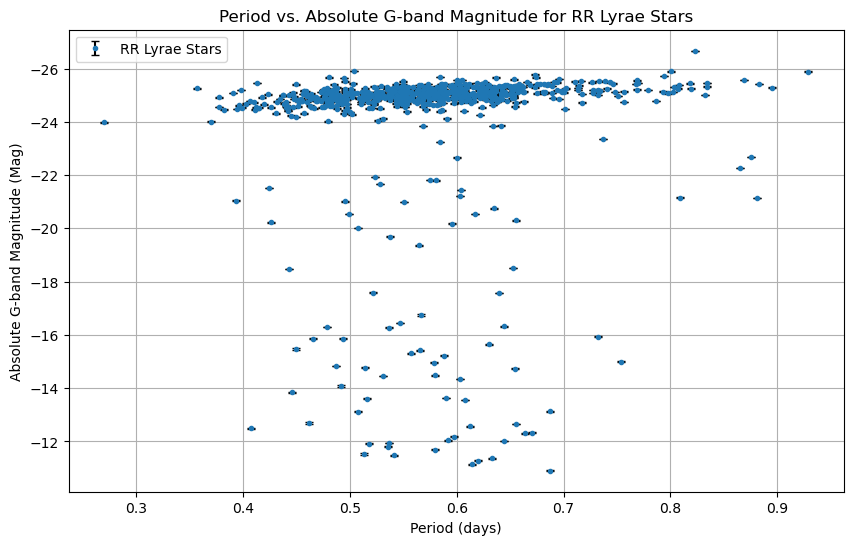

In [66]:
mean_mags = []
mean_mag_errors = []

for index, row in rrlyrae_gaia_joined_data_df.iterrows():
    flux = row['flux']  
    flux_err = row['flux_err']
    mean_mag = -2.5 * np.log10(flux)
    mean_mag_err = (2.5 / np.log(10)) * (flux_err / flux)
    
    mean_mags.append(mean_mag)
    mean_mag_errors.append(mean_mag_err)

mean_mags = np.array(mean_mags)
mean_mag_errors = np.array(mean_mag_errors)

distances = rrlyrae_gaia_joined_data_df['distance_pc'].values 
absolute_g_mags = mean_mags - 5 * (np.log10(distances) - 1)

periods = rrlyrae_gaia_joined_data_df['period'].values 

plt.figure(figsize=(10, 6))
plt.errorbar(periods, absolute_g_mags, yerr=mean_mag_errors, fmt='o', ecolor='black', capsize=3, ms=3, label='RR Lyrae Stars')
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude (Mag)')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars')
plt.gca().invert_yaxis() 
plt.grid(True)
plt.legend()
plt.show()

In [50]:
def uwe_cut(g_mag, uwe):
    # Equation C1: u < 1.2 * max(1, exp(-0.2 * (G - 19.5)))
    threshold = 1.2 * np.maximum(1, np.exp(-0.2 * (g_mag - 19.5)))
    return uwe < threshold

def flux_excess_cut(gbp_minus_grp, excess_ratio):
    # Equation C2: 1.0 + 0.015 * (GBP - GRP)^2 < E < 1.3 + 0.06 * (GBP - GRP)^2
    lower_limit = 1.0 + 0.015 * (gbp_minus_grp ** 2)
    upper_limit = 1.3 + 0.06 * (gbp_minus_grp ** 2)
    return (excess_ratio > lower_limit) & (excess_ratio < upper_limit)


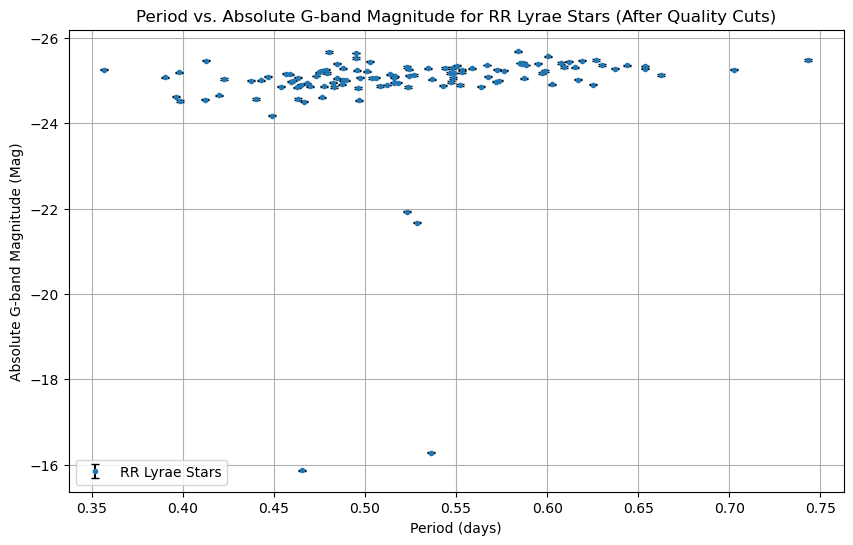

In [68]:
filtered_rrlyrae_df = rrlyrae_gaia_joined_data_df[
    uwe_cut(rrlyrae_gaia_joined_data_df['g_mag'], rrlyrae_gaia_joined_data_df['uwe']) &
    flux_excess_cut(rrlyrae_gaia_joined_data_df['gbp_minus_grp'], rrlyrae_gaia_joined_data_df['excess_ratio'])
]

mean_mags = []
mean_mag_errors = []

for index, row in filtered_rrlyrae_df.iterrows():
    flux = np.array([row['flux']])  # Wrap scalar flux in an array
    flux_err = np.array([row['flux_err']])  # Wrap scalar flux error in an array
    
    mean_mag, mean_mag_err = calculate_mean_magnitude(flux, flux_err)
    
    mean_mags.append(mean_mag)
    mean_mag_errors.append(mean_mag_err)

mean_mags = np.array(mean_mags)
mean_mag_errors = np.array(mean_mag_errors)

distances = filtered_rrlyrae_df['distance_pc'].values  # Distance in parsecs
absolute_g_mags = mean_mags - 5 * (np.log10(distances) - 1)

periods = filtered_rrlyrae_df['period'].values  # Periods from the dataset

plt.figure(figsize=(10, 6))
plt.errorbar(periods, absolute_g_mags, yerr=mean_mag_errors, fmt='o', ecolor='black', capsize=3, markersize=3, label='RR Lyrae Stars')
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude (Mag)')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars (After Quality Cuts)')
plt.gca().invert_yaxis()  # Magnitudes are brighter at the top
plt.grid(True)
plt.legend()
plt.show()

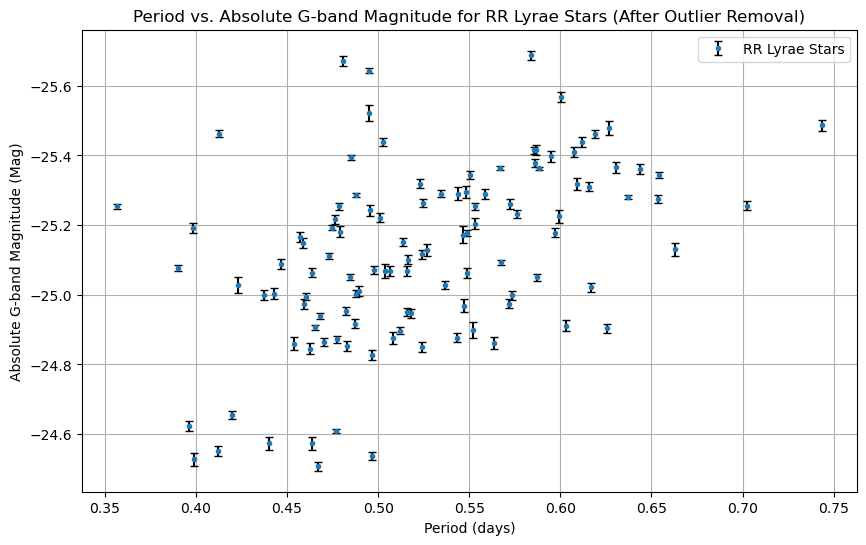

In [69]:
outlier_mask = absolute_g_mags < -24.4
absolute_g_mags = absolute_g_mags[outlier_mask]
mean_mag_errors = mean_mag_errors[outlier_mask]
periods = periods[outlier_mask]

plt.figure(figsize=(10, 6))
plt.errorbar(periods, absolute_g_mags, yerr=mean_mag_errors, fmt='o', ecolor='black', capsize=3, markersize=3, label='RR Lyrae Stars')
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude (Mag)')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars (After Outlier Removal)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

In [70]:
def gaussian(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def log_gaussian(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - (x - mu)**2 / (2 * sigma**2)

def metropolis_hastings(num_samples, mu, sigma, proposal_width):
    samples = np.zeros(num_samples)
    samples[0] = np.random.normal(mu, sigma) 
    log_prob = log_gaussian(samples[0], mu, sigma)
    
    accept_count = 0
    
    for i in range(1, num_samples):
        proposal = samples[i-1] + np.random.normal(0, proposal_width)
        log_prob_new = log_gaussian(proposal, mu, sigma)
        acceptance_ratio = np.exp(log_prob_new - log_prob)
        if np.random.rand() < acceptance_ratio:
            samples[i] = proposal 
            log_prob = log_prob_new
            accept_count += 1
        else:
            samples[i] = samples[i-1]  

    acceptance_fraction = accept_count / num_samples
    return samples, acceptance_fraction

num_samples = 10000
mu = 1
sigma = 0.1
proposal_width = 0.1  

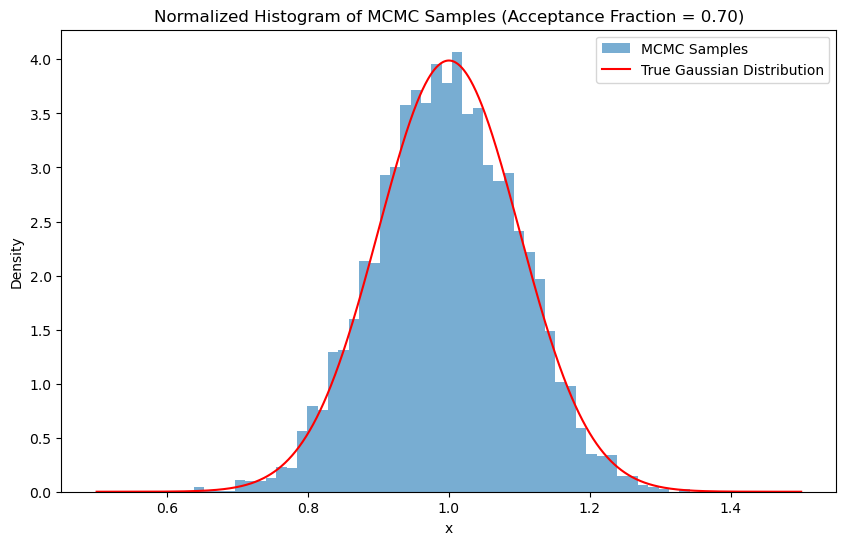

In [71]:

samples, acceptance_fraction = metropolis_hastings(num_samples, mu, sigma, proposal_width)

x_values = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
true_distribution = gaussian(x_values, mu, sigma)

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='MCMC Samples')
plt.plot(x_values, true_distribution, label='True Gaussian Distribution', color='red')
plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Normalized Histogram of MCMC Samples (Acceptance Fraction = {acceptance_fraction:.2f})')
plt.legend()
plt.show()

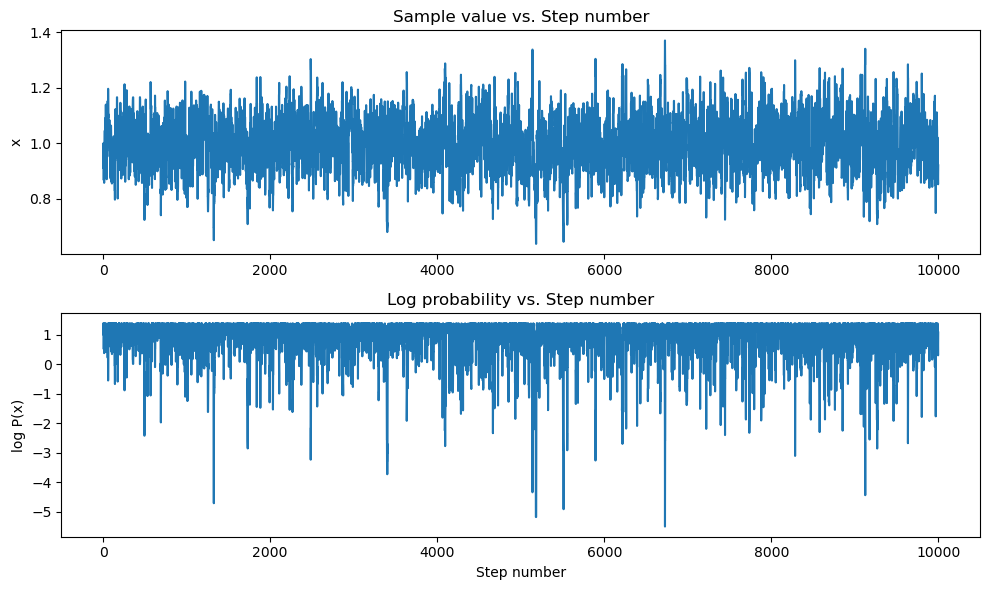

In [72]:
log_probs = [log_gaussian(x, mu, sigma) for x in samples]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(samples)
plt.ylabel('x')
plt.title('Sample value vs. Step number')

plt.subplot(2, 1, 2)
plt.plot(log_probs)
plt.xlabel('Step number')
plt.ylabel('log P(x)')
plt.title('Log probability vs. Step number')
plt.tight_layout()
plt.show()

In [73]:
def log_likelihood(data, periods, a, b, sigma_scatter):
    M_g, M_g_errors = data
    model = a * np.log10(periods) + b
    total_variance = M_g_errors**2 + sigma_scatter**2
    log_likelihood = -0.5 * np.sum((M_g - model)**2 / total_variance + np.log(2 * np.pi * total_variance))
    return log_likelihood

def log_prior(a, b, sigma_scatter):
    if -10 < a < 10 and -20 < b < 5 and 0 < sigma_scatter < 5:
        return 0  
    return -np.inf

def log_posterior(params, data, periods):
    a, b, sigma_scatter = params
    lp = log_prior(a, b, sigma_scatter)
    if np.isinf(lp):
        return lp
    return lp + log_likelihood(data, periods, a, b, sigma_scatter)

def metropolis_hastings_mcmc_adaptive(data, periods, num_samples, initial_proposal_widths, initial_params, adapt_steps=1000):
    samples = np.zeros((num_samples, 3))
    samples[0] = initial_params 
    current_log_prob = log_posterior(samples[0], data, periods)

    accept_count = 0
    proposal_widths = np.array(initial_proposal_widths)

    for i in range(1, num_samples):
        proposal = samples[i-1] + np.random.normal(0, proposal_widths, 3)
        proposal_log_prob = log_posterior(proposal, data, periods)
        acceptance_ratio = np.exp(proposal_log_prob - current_log_prob)

        if np.random.rand() < acceptance_ratio:
            samples[i] = proposal
            current_log_prob = proposal_log_prob
            accept_count += 1
        else:
            samples[i] = samples[i-1]

        # Adapt proposal widths
        if i < adapt_steps:
            acceptance_fraction = accept_count / i
            for j in range(3):
                if acceptance_fraction < 0.2:
                    proposal_widths[j] *= 0.9
                elif acceptance_fraction > 0.5:
                    proposal_widths[j] *= 1.1

    acceptance_fraction = accept_count / num_samples
    return samples, acceptance_fraction

def neg_log_likelihood(params, data, periods):
    return -log_likelihood(data, periods, *params)

periods = np.array(filtered_rrlyrae_df['period'])
M_g = absolute_g_mags  
M_g_errors = mean_mag_errors

min_len = min(len(periods), len(M_g))
periods = periods[:min_len]
M_g = M_g[:min_len]
M_g_errors = M_g_errors[:min_len]

data = (M_g, M_g_errors)

initial_guess = [0.0, 0.0, 1.0]
result = minimize(neg_log_likelihood, initial_guess, args=(data, periods),
                  bounds=[(-10, 10), (-20, 5), (0, 5)])

if result.success:
    initial_params = result.x
else:
    raise RuntimeError("Optimization failed. Check your model and data.")

Acceptance Fraction: 0.45


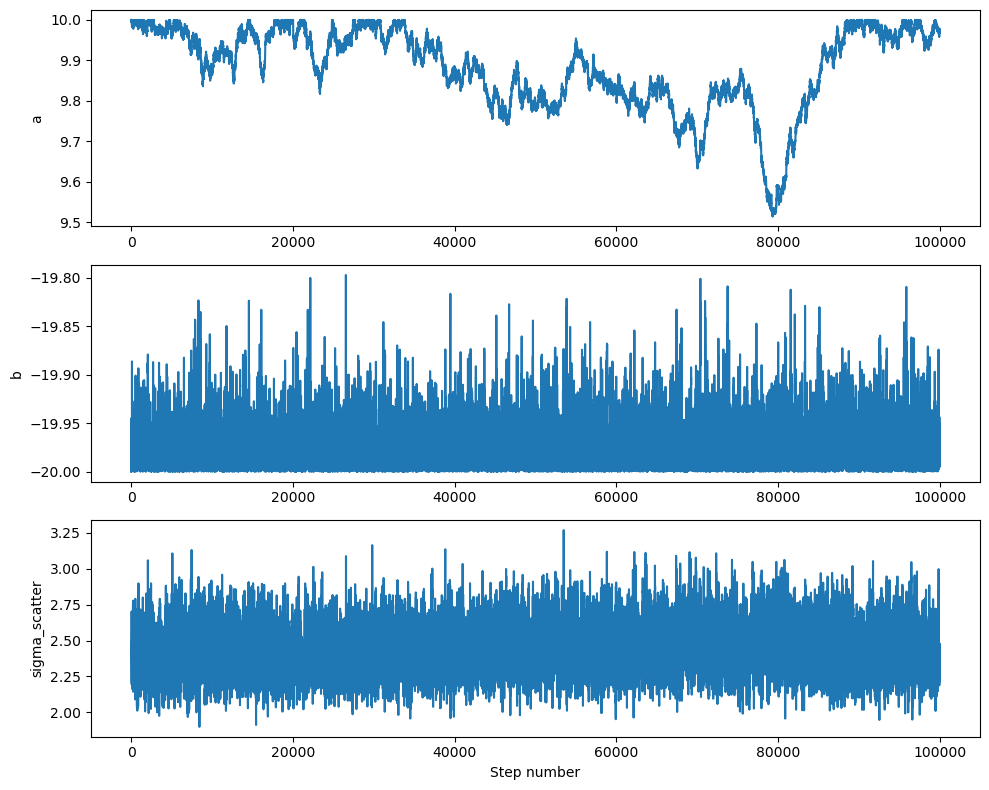

In [80]:
num_samples = 100000
proposal_widths = [0.001, 0.01, 0.05]
samples_ii, acceptance_fraction = metropolis_hastings_mcmc_adaptive(data, periods, num_samples, proposal_widths, initial_params)

print(f'Acceptance Fraction: {acceptance_fraction:.2f}')

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
param_labels = ['a', 'b', 'sigma_scatter']
for i in range(3):
    axes[i].plot(samples_ii[:, i])
    axes[i].set_ylabel(param_labels[i])
plt.xlabel('Step number')
plt.tight_layout()
plt.show()


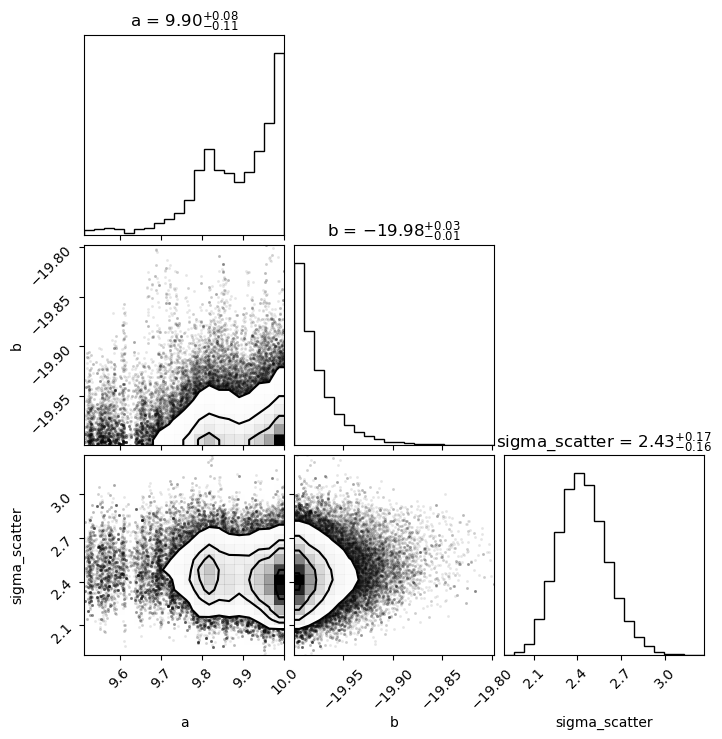

In [81]:
corner.corner(samples_ii, labels=param_labels, show_titles=True)
plt.show()

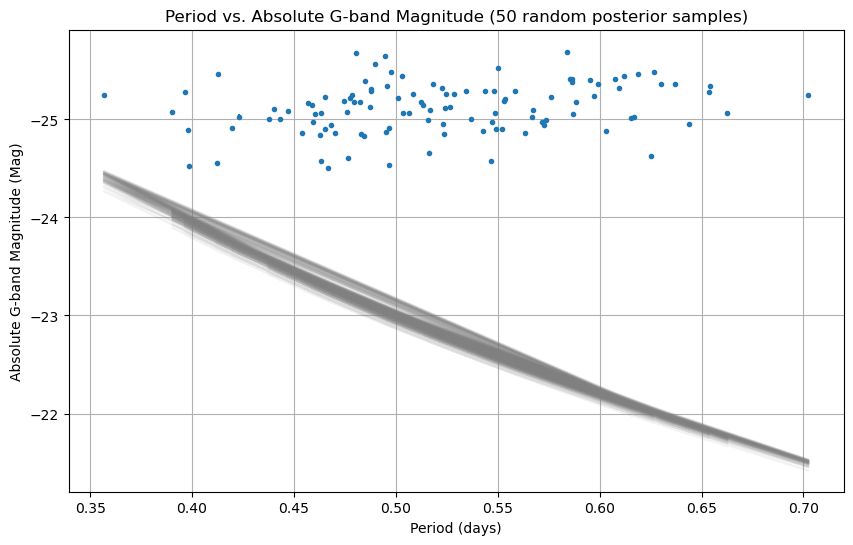

In [82]:
plt.figure(figsize=(10, 6))
plt.errorbar(periods, M_g, yerr=M_g_errors, fmt='o', label='Data', markersize=3)

for s in samples_ii[np.random.choice(len(samples_ii), 50, replace=False)]:
    a, b, _ = s
    model = a * np.log10(periods) + b
    plt.plot(periods, model, color='gray', alpha=0.1)

plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude (Mag)')
plt.title('Period vs. Absolute G-band Magnitude (50 random posterior samples)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


### Priors Assumed

In the MCMC model for estimating the parameters \(a\), \(b\), and \(\sigma_{\text{scatter}}\) in the RR Lyrae period-luminosity relation, we assume the following **flat priors** for each of the parameters:

1. **Prior on \(a\)** (slope of the period-luminosity relation):
   $a \sim \mathcal{U}(-10, 10)$  
   This is a **uniform prior** between -10 and 10, meaning that we assume no prior knowledge about the slope, and all values within this range are equally likely.

2. **Prior on \(b\)** (intercept of the period-luminosity relation):
   $b \sim \mathcal{U}(-20, 5)$  
   Similarly, this is a **uniform prior** between -20 and 5, which indicates no prior preference for values of \(b\) within this range.

3. **Prior on $(\sigma_{\text{scatter}}$** (intrinsic scatter in the relation):
   $\sigma_{\text{scatter}} \sim \mathcal{U}(0, 5)$  
   This is a **uniform prior** between 0 and 5, reflecting our assumption that the intrinsic scatter must be a positive value, but we have no prior knowledge about its exact value within this range.

### Posterior Probability Distribution
Using **Bayes' Theorem**, the posterior probability distribution for the parameters $a$, $b$, and $\sigma_{\text{scatter}}$, given the data $\vec{d}$, is computed as follows:

$$
p(a, b, \sigma_{\text{scatter}} | \vec{d}) = \frac{p(\vec{d} | a, b, \sigma_{\text{scatter}}) \cdot p(a, b, \sigma_{\text{scatter}})}{p(\vec{d})}
$$


Where:
- $p(a, b, \sigma_{\text{scatter}} | \vec{d})$ is the **posterior probability** of the parameters given the data.
- $p(\vec{d} | a, b, \sigma_{\text{scatter}})$ is the **likelihood function**, which describes how likely the observed data is given the parameters.
- $p(a, b, \sigma_{\text{scatter}})$ is the **prior** distribution, which encodes our assumptions about the parameters before seeing the data.
- $p(\vec{d})$ is the **evidence**, a normalizing constant that ensures the posterior is a valid probability distribution. The evidence is not necessary for MCMC sampling since it only involves relative probabilities.

### Likelihood Function

The likelihood function $p(\vec{d} | a, b, \sigma_{\text{scatter}})$ is modeled as a Gaussian, accounting for the intrinsic scatter $\sigma_{\text{scatter}}$ and the measurement uncertainties in the absolute magnitudes:

$$
\mathcal{L}(a, b, \sigma_{\text{scatter}}) = \prod_i \frac{1}{\sqrt{2 \pi (\sigma_{\text{mag}, i}^2 + \sigma_{\text{scatter}}^2)}} \exp\left(- \frac{(M_{G, i} - (a \log P_i + b))^2}{2 (\sigma_{\text{mag}, i}^2 + \sigma_{\text{scatter}}^2)}\right)
$$

Where:
- $M_{G, i}$ are the observed absolute magnitudes,
- $P_i$ are the periods of the RR Lyrae stars,
- $\sigma_{\text{mag}, i}$ are the measurement uncertainties in the magnitudes,
- $\sigma_{\text{scatter}}$ is the intrinsic scatter in the period-luminosity relation.

### Consistency

The spread between the posterior samples (gray lines) is not consistent with the observed spread in the data. The model is forcing a downward slope, while the actual data points do not follow this trend. The key reasons for this inconsistency could be:

- The period-luminosity relation assumed by the model does not fully explain the behavior of the RR Lyrae stars in the sample.
- The intrinsic scatter is not sufficient to capture the actual variability in the data.
- The data may suffer from measurement uncertainties that the model is not accounting for.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma_scatter]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


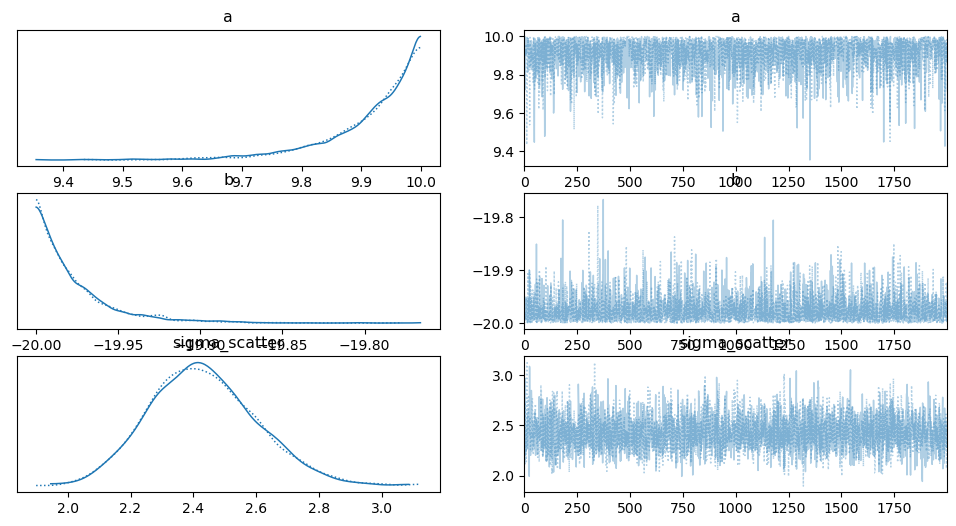

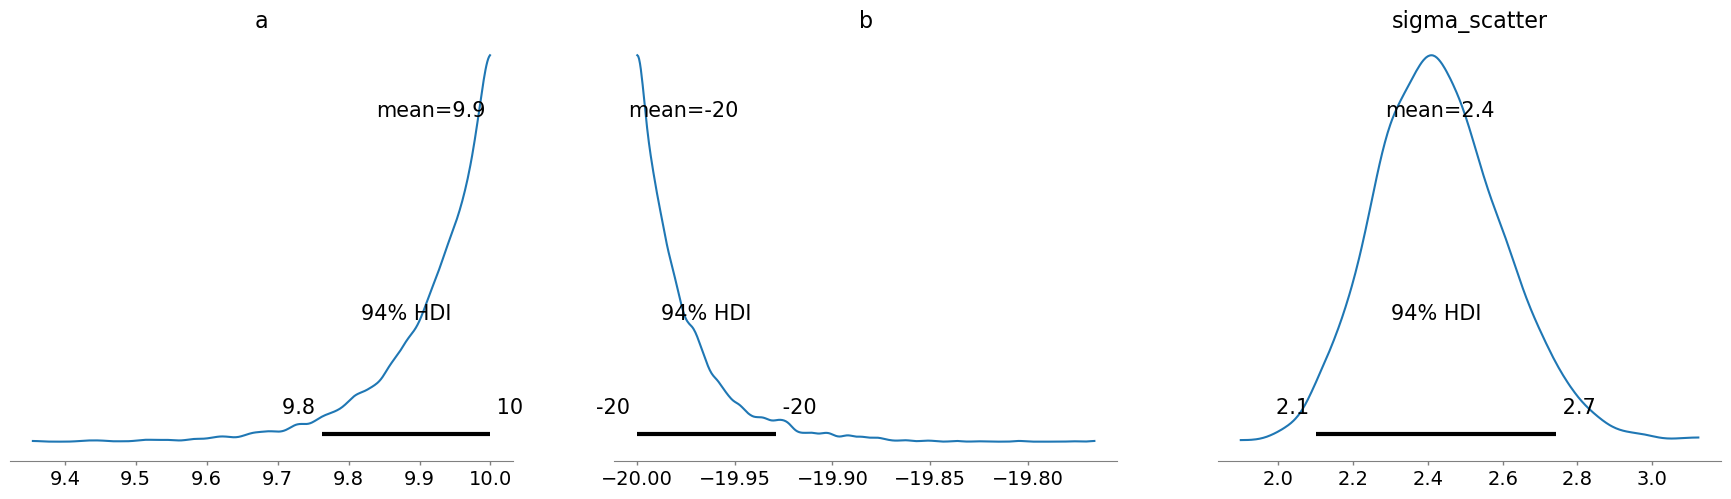

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a               9.916  0.083   9.762   10.000      0.002    0.001    1538.0   
b             -19.976  0.025 -20.000  -19.929      0.000    0.000    2572.0   
sigma_scatter   2.432  0.173   2.100    2.742      0.003    0.002    2999.0   

               ess_tail  r_hat  
a                1243.0    1.0  
b                1707.0    1.0  
sigma_scatter    2470.0    1.0  


In [84]:
periods = np.array(filtered_rrlyrae_df['period'])  
M_g = absolute_g_mags  
M_g_errors = mean_mag_errors 

min_len = min(len(periods), len(M_g), len(M_g_errors))

periods = periods[:min_len]
M_g = M_g[:min_len]
M_g_errors = M_g_errors[:min_len]

with pm.Model() as model:
    a = pm.Uniform("a", lower=-10, upper=10)
    b = pm.Uniform("b", lower=-20, upper=5)
    sigma_scatter = pm.Uniform("sigma_scatter", lower=0, upper=5)

    # Define the mean as μ = a * log10(periods) + b
    mu = a * (pm.math.log(periods) / pm.math.log(10)) + b

    # Define the total variance as σ² = σ_scatter² + σ_i² (M_g_errors)
    total_variance = M_g_errors**2 + sigma_scatter**2

    # Likelihood: The observed M_g follows a Normal distribution centered at mu with std sqrt(total_variance)
    M_g_obs = pm.Normal("M_g_obs", mu=mu, sigma=pm.math.sqrt(total_variance), observed=M_g)

    trace_iii = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2, target_accept=0.95)

az.plot_trace(trace_iii)
plt.show()

az.plot_posterior(trace_iii)
plt.show()
print(az.summary(trace_iii))

samples_iii = np.vstack([trace_iii.posterior["a"].values.flatten(),
                         trace_iii.posterior["b"].values.flatten(),
                         trace_iii.posterior["sigma_scatter"].values.flatten()]).T


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma_scatter]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


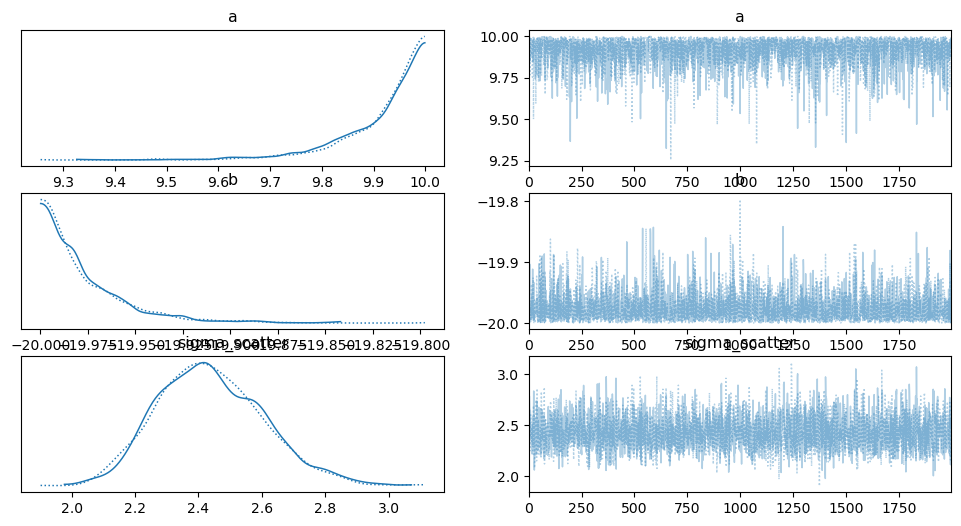

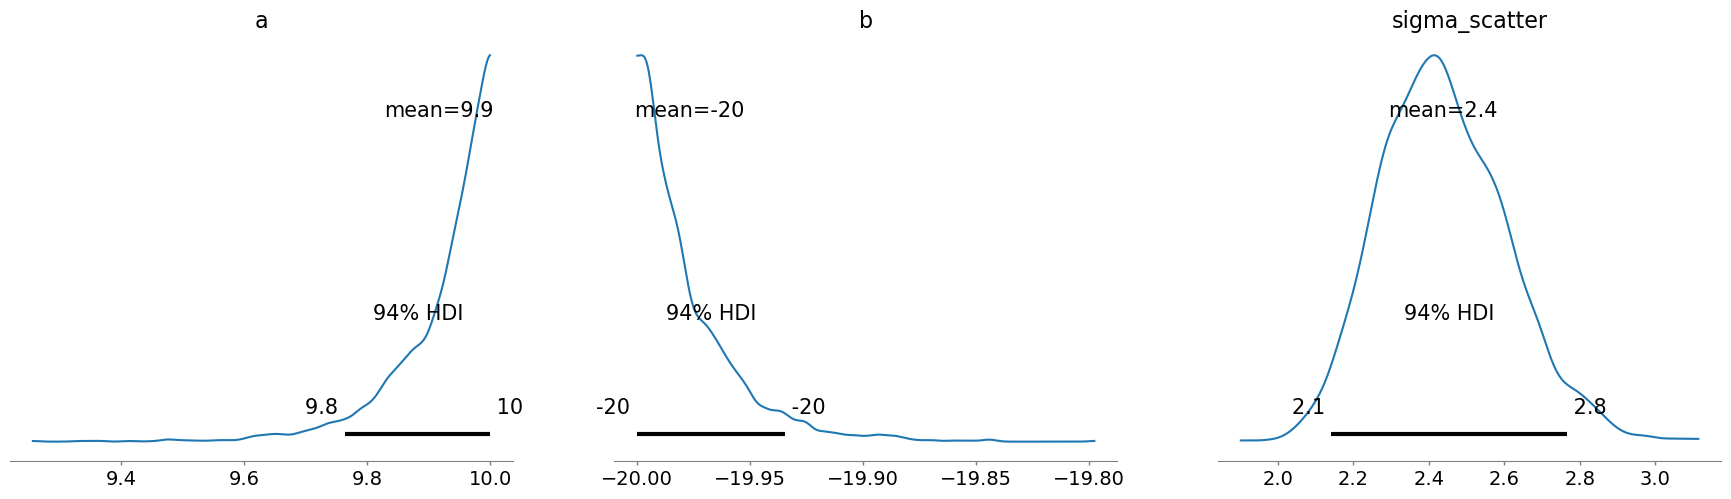

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a               9.916  0.086   9.764   10.000      0.002    0.001    1847.0   
b             -19.977  0.023 -20.000  -19.934      0.000    0.000    2658.0   
sigma_scatter   2.438  0.168   2.142    2.766      0.003    0.002    3111.0   

               ess_tail  r_hat  
a                1203.0    1.0  
b                2023.0    1.0  
sigma_scatter    2458.0    1.0  


In [85]:
periods = np.array(filtered_rrlyrae_df['period'])
M_g = absolute_g_mags
M_g_errors = mean_mag_errors

min_len = min(len(periods), len(M_g))
periods = periods[:min_len]
M_g = M_g[:min_len]
M_g_errors = M_g_errors[:min_len]

with pm.Model() as model:
    a = pm.Uniform("a", lower=-10, upper=10)
    b = pm.Uniform("b", lower=-20, upper=5)
    sigma_scatter = pm.Uniform("sigma_scatter", lower=0, upper=5)
    
    mu = a * (pm.math.log(periods) / pm.math.log(10)) + b
    
    total_variance = M_g_errors**2 + sigma_scatter**2
    
    M_g_obs = pm.Normal("M_g_obs", mu=mu, sigma=pm.math.sqrt(total_variance), observed=M_g)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True, cores=2, target_accept=0.95)

az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()

print(az.summary(trace))

samples_iv = np.vstack([
    trace.posterior["a"].values.flatten(),
    trace.posterior["b"].values.flatten(),
    trace.posterior["sigma_scatter"].values.flatten()
]).T



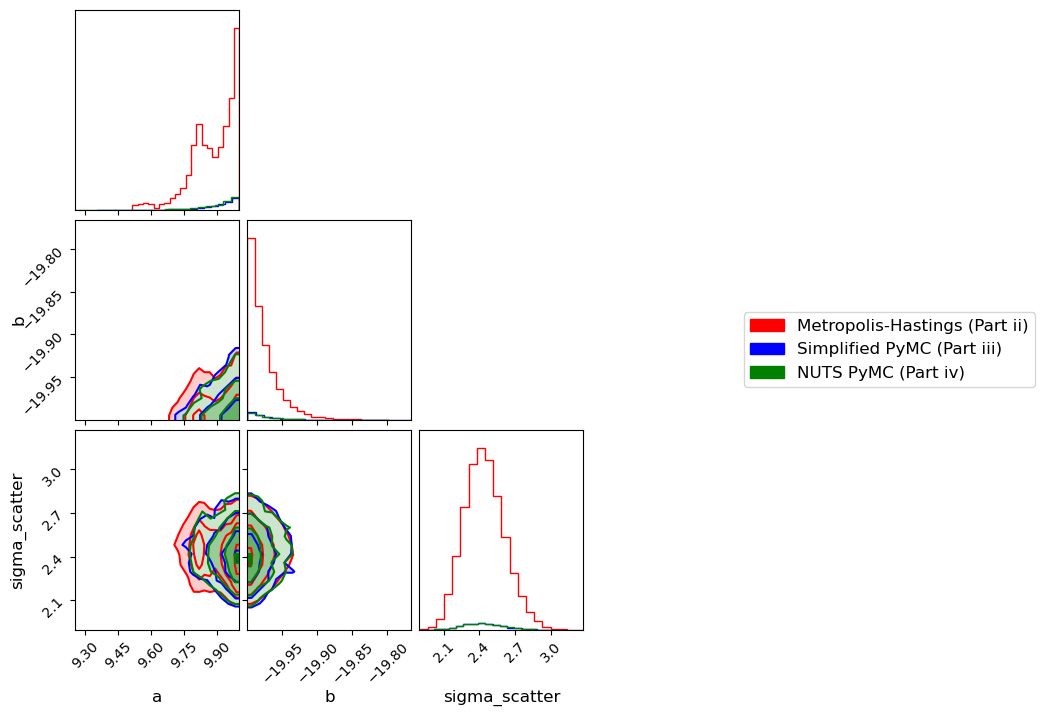

In [86]:
samples_ii = samples_ii[:, :3]

# samples_iii = np.vstack([
#     trace_iii.posterior["a"].values.flatten(),
#     trace_iii.posterior["b"].values.flatten(),
#     trace_iii.posterior["sigma_scatter"].values.flatten()
# ]).T


# samples_iv = np.vstack([
#     trace.posterior["a"].values.flatten(),
#     trace.posterior["b"].values.flatten(),
#     trace.posterior["sigma_scatter"].values.flatten()
# ]).T

labels = ['a', 'b', 'sigma_scatter']
data_ii = samples_ii  
data_iii = samples_iii
data_iv = samples_iv  

figure = corner.corner(data_ii, labels=labels, color='red', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "red"})

corner.corner(data_iii, labels=labels, color='blue', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "blue"}, fig=figure)

corner.corner(data_iv, labels=labels, color='green', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "green"}, fig=figure)

plt.subplots_adjust(right=0.8)

red_patch = mpatches.Patch(color='red', label='Metropolis-Hastings (Part ii)')
blue_patch = mpatches.Patch(color='blue', label='Simplified PyMC (Part iii)')
green_patch = mpatches.Patch(color='green', label='NUTS PyMC (Part iv)')

plt.gcf().legend(handles=[red_patch, blue_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()
